<a href="https://colab.research.google.com/github/GabCopetti/Chest-X-Rays-Binary-Classification/blob/main/Chest_XRays_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
## 1. Setting up environment
***

In [1]:
#Installing specific Python version
!sudo apt-get install python3.10
!python --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Python 3.10.12


In [2]:
#Installing necessary packages

#Disabling output
%%capture
!pip install torch==2.3.1+cu121
!pip install torchvision==0.18.1+cu121
!pip install datasets==2.20.0
!pip install matplotlib==3.7.1
!pip install requests==2.32.3
!pip install torchmetrics==1.4.0.post0
!pip install tqdm==4.66.4
!pip install sklearn==2.2.0

In [3]:
#Importing libraries

#Torch
import torch
from torch import nn

#Torchvision
import torchvision
from torchvision.transforms import functional as F

#Import datasets from Hugging Face
import datasets
from datasets import load_dataset

#Matplotlib
import matplotlib.pyplot as plt

#Importing Path to download helper functions from Learn PyTorch repo
import requests
from pathlib import Path

#Importing DataLoader
from torch.utils.data import DataLoader

#Importing tqdm for progress bar
from tqdm.auto import tqdm

#To use in the plotting function
from typing import Dict, List

#For evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


In [4]:
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [5]:
#Import accuracy metric
from helper_functions import accuracy_fn

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

***
## 2. Data preparation
***

In [7]:
#Loading datasets
train_dataset = load_dataset("keremberke/chest-xray-classification", "full", split="train")
valid_dataset = load_dataset("keremberke/chest-xray-classification", "full", split="validation")
test_dataset = load_dataset("keremberke/chest-xray-classification", "full", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4077 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1165 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/582 [00:00<?, ? examples/s]

In [8]:
train_dataset[0]

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/60340657865253-config-parquet-and-info-keremberke-chest-xray-cla-9d66ea8b/downloads/extracted/8202f7dd6f1edf5e674abe75990eb233fbbca4408e132a3acd5268bd99708e15/NORMAL/IM-0003-0001_jpeg.rf.3fffcf9c33575f8f928b017484f99a64.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'labels': 0}

In [9]:
#Changing format to torch.Tensor and losing image_file_path
format = {'type': 'torch', 'device': torch.device(device), 'columns': ['image','labels'], 'format_kwargs':{'dtype': torch.float}}
train_dataset.set_format(**format )
valid_dataset.set_format(**format )
test_dataset.set_format(**format )

In [10]:
train_dataset[0]

{'image': tensor([[[  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 106., 107.,  40.],
          ...,
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.]],
 
         [[  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 106., 107.,  40.],
          ...,
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.]],
 
         [[  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 107., 107.,  40.],
          [  0.,  28.,  39.,  ..., 106., 107.,  40.],
          ...,
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,  40.,  ...,  34.,  32.,  14.],
          [  1.,  27.,

In [11]:
train_dataset[0]['image'].shape

torch.Size([3, 640, 640])

In [12]:
def transform(example):
    #Transforming channel number = 3 to channnel number = 1
    example['image'] = F.rgb_to_grayscale(example['image'], num_output_channels=1)
    #Converting pixel values from 0-255 to 0-1
    example['image'] = example['image']/255
    return example

In [13]:
#Applying transformations to sets
train_dataset = train_dataset.map(transform, batched= True, batch_size=32)
valid_dataset = valid_dataset.map(transform, batched= True, batch_size=32)
test_dataset = test_dataset.map(transform, batched= True, batch_size=32)

Map:   0%|          | 0/4077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1165 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

In [14]:
train_dataset[0]

{'image': tensor([[[0.0000, 0.1098, 0.1529,  ..., 0.4196, 0.4196, 0.1568],
          [0.0000, 0.1098, 0.1529,  ..., 0.4196, 0.4196, 0.1568],
          [0.0000, 0.1098, 0.1529,  ..., 0.4156, 0.4196, 0.1568],
          ...,
          [0.0039, 0.1059, 0.1568,  ..., 0.1333, 0.1255, 0.0549],
          [0.0039, 0.1059, 0.1568,  ..., 0.1333, 0.1255, 0.0549],
          [0.0039, 0.1059, 0.1568,  ..., 0.1333, 0.1255, 0.0549]]]),
 'labels': tensor(0.)}

In [15]:
train_dataset[0]['image'].shape

torch.Size([1, 640, 640])

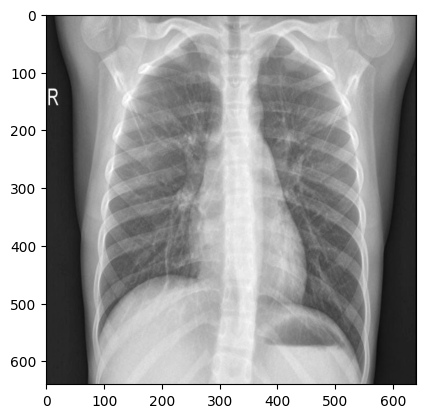

In [16]:
#Checking if image is unchanged after transformation
plt.imshow(train_dataset[0]['image'].squeeze().cpu(), cmap='gray')

In [17]:
#Setting up DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader((train_dataset), # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

valid_dataloader = DataLoader((valid_dataset),
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the validation data
)

test_dataloader = DataLoader((test_dataset),
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

print(f"Dataloaders: {train_dataloader, valid_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7dbdd7bcc5b0>, <torch.utils.data.dataloader.DataLoader object at 0x7dbdd7bcd3f0>, <torch.utils.data.dataloader.DataLoader object at 0x7dbdd7bcd3c0>)
Length of train dataloader: 128 batches of 32
Length of validation dataloader: 37 batches of 32
Length of test dataloader: 19 batches of 32


***
## 3. Defining functions (loss, training, validation, testing)
***

In [18]:
# Set up loss functions

# Without weight
loss_fn = nn.BCEWithLogitsLoss()

# With weight to take into account class imbalance
# pos_weight = 0/1 ratio = 0.37
loss_fn_weighed = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([0.37]).to(device))

In [19]:
# Set up train, validation and testing steps

#Train
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    #List to store true values and predictions
    y_true_list = []
    y_pred_list = []
    #Loss and accuracy variables
    train_loss, train_acc = 0, 0

    #Put model in train mode
    model.to(device)
    model.train()

    #Loop through batches
    for batch, entry in enumerate(data_loader):
        X = entry['image'].to(device)
        y = entry['labels'].to(device)
        y_true_list.append(y)

        # 1. Forward pass
        y_logits = model(X).squeeze().to(device) # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
        y_pred = torch.round(torch.sigmoid(y_logits)).to(device)
        with torch.no_grad():
            y_pred_list.append(y_pred)

        # 2. Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 32 == 0:
            print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

    # Calculate loss, accuracy and f1 score per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    y_true_list = torch.cat(y_true_list).detach().cpu().numpy()
    y_pred_list = torch.cat(y_pred_list).detach().cpu().numpy()
    train_f1 = f1_score(y_true_list, y_pred_list)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Train F1: {train_f1:.2f}")
    return train_loss, train_acc, train_f1


#Validation step
def valid_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    y_true_list = []
    y_pred_list = []
    valid_loss, valid_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for entry in data_loader:
            # Send data to GPU
            X = entry['image'].to(device)
            y = entry['labels'].to(device)
            y_true_list.append(y)

            # 1. Forward pass
            valid_logits = model(X).squeeze().to(device)
            valid_pred = torch.round(torch.sigmoid(valid_logits)).to(device)
            y_pred_list.append(valid_pred)

            # 2. Calculate loss and accuracy
            valid_loss += loss_fn(valid_logits, y).item()
            valid_acc += accuracy_fn(y_true=y, y_pred=valid_pred)

        # Adjust metrics and print out
        valid_loss /= len(data_loader)
        valid_acc /= len(data_loader)
        y_true_list = torch.cat(y_true_list).cpu()
        y_pred_list = torch.cat(y_pred_list).cpu()
        valid_f1 = f1_score(y_true_list, y_pred_list)
        print(f"Validation loss: {valid_loss:.5f} | Validation accuracy: {valid_acc:.2f}%\n | Validation F1: {valid_f1:.2f}")
        return valid_loss, valid_acc, valid_f1


#Testing step
def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    y_true = []
    y_pred = []
    test_acc, test_f1 = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for entry in data_loader:
            # Send data to GPU
            X = entry['image'].to(device)
            y = entry['labels'].to(device)
            y_true.append(y)

            # 1. Forward pass
            test_logits = model(X).squeeze().to(device)
            test_pred = torch.round(torch.sigmoid(test_logits)).to(device)
            y_pred.append(test_pred)

            # 2. Calculate accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        # Adjust metrics and return
        y_true = torch.cat(y_true).to('cpu')
        y_true = torch.Tensor.numpy(y_true)
        y_pred = torch.cat(y_pred).to('cpu')
        y_pred = torch.Tensor.numpy(y_pred)
        test_acc /= len(data_loader)
        test_f1 += f1_score(y_true=y_true, y_pred=y_pred)

        results = {
            "test_acc": test_acc,
            "test_f1": test_f1
        }

        return results, y_true, y_pred

In [20]:
torch.manual_seed(42)

# 1. Take in various parameters required for training and validation steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):

    # Create empty results dictionary
    results = {"train_loss": [],
            "train_acc": [],
            "train_f1": [],
            "valid_loss": [],
            "valid_acc": [],
            "valid_f1": []
              }

    # Train and validate model
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n---------")
        train_loss, train_acc, train_f1 = train_step(data_loader=train_dataloader,
                                        model=model,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        accuracy_fn=accuracy_fn,
                                        device=device
                                        )
        valid_loss, valid_acc, valid_f1 = valid_step(data_loader=valid_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device
                                    )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_f1"].append(train_f1)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)
        results["valid_f1"].append(valid_f1)

    # Return the filled results at the end of the epochs
    return results

***
## 4. Function to plot loss and accuracy graphs
***

In [21]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "valid_loss": [...],
             "valid_acc": [...]}
             "train_f1": [...],
             "valid_f1": [...]}
    """

    # Get the loss values of the results dictionary (training and validation)
    loss = results['train_loss']
    valid_loss = results['valid_loss']

    # Get the accuracy values of the results dictionary (training and validation)
    accuracy = results['train_acc']
    valid_accuracy = results['valid_acc']

    # Get the f1 values of the results dictionary (training and validation)
    f1 = torch.tensor(results['train_f1']).detach().cpu().numpy()
    valid_f1 = torch.tensor(results['valid_f1']).detach().cpu().numpy()

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 15))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, valid_loss, label='valid_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, valid_accuracy, label='valid_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

    # Plot F1
    plt.subplot(2, 2, 3)
    plt.plot(epochs, f1, label='train_f1')
    plt.plot(epochs, valid_f1, label='valid_f1')
    plt.title('F1')
    plt.xlabel('Epochs')
    plt.legend();

***
## 5. Setting up model classes
***

### Linear models

In [22]:
#Two linear layers
class XRAYS_linear2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [23]:
#Three linear layers
class XRAYS_linear3(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [24]:
#Four linear layers
class XRAYS_linear4(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

### Non-linear models

In [25]:
# Two layers
class XRAYS_linear2ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattens inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [26]:
# Three layers
class XRAYS_linear3ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [27]:
# Four layers
class XRAYS_linear4ReLU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), #adds non-linearity
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() #adds non-linearity
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


### Convolutional Neural Networks

In [28]:
# Create a convolutional neural network

#One linear layer at the end

class XRAYS_CNN(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*25600,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [29]:
#Two linear layers at the end

class XRAYS_CNN2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*25600,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)

        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

***
## 6. Experiment
***

### a. Linear models - Changing number of **layers**

#### Setting up the models

In [ ]:
torch.manual_seed(42)

#Linear layers: 2

model_0 = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_0.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
#Model optimizer
optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=0.0001)

In [ ]:
torch.manual_seed(42)

#Linear layers: 3

model_1 = XRAYS_linear3(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_1.to(device)

XRAYS_linear3(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.0001)

In [ ]:
torch.manual_seed(42)

#Linear layers: 4

model_2 = XRAYS_linear4(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_2.to(device)

XRAYS_linear4(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.0001)

***
#### Training
***

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Linear layers: 2

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_0,
                        loss_fn=loss_fn,  #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.48387 | Train accuracy: 76.92% | Train F1: 0.86
Validation loss: 0.37860 | Validation accuracy: 88.34%
 | Validation F1: 0.93
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.36397 | Train accuracy: 85.70% | Train F1: 0.91
Validation loss: 0.30729 | Validation accuracy: 87.42%
 | Validation F1: 0.92
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.31216 | Train accuracy: 88.50% | Train F1: 0.93
Validation loss: 0.27429 | Validation accuracy: 91.68%
 | Validation F1: 0.94
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.28217 | Train accuracy: 89.60% | Train F1: 0.93
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear layers: 3
# Train model
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_1,
                        loss_fn=loss_fn,  #no weight
                        epochs=NUM_EPOCHS)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.52937 | Train accuracy: 73.03% | Train F1: 0.84
Validation loss: 0.45204 | Validation accuracy: 76.10%
 | Validation F1: 0.86
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.43411 | Train accuracy: 79.30% | Train F1: 0.88
Validation loss: 0.38274 | Validation accuracy: 80.15%
 | Validation F1: 0.88
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37871 | Train accuracy: 84.49% | Train F1: 0.90
Validation loss: 0.34059 | Validation accuracy: 89.27%
 | Validation F1: 0.93
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.34271 | Train accuracy: 87.16% | Train F1: 0.92
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear layers:4
# Train model
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_2,
                        loss_fn=loss_fn,  #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.55963 | Train accuracy: 72.29% | Train F1: 0.84
Validation loss: 0.50823 | Validation accuracy: 74.32%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.49664 | Train accuracy: 73.70% | Train F1: 0.85
Validation loss: 0.45411 | Validation accuracy: 74.83%
 | Validation F1: 0.85
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.45035 | Train accuracy: 76.36% | Train F1: 0.86
Validation loss: 0.41576 | Validation accuracy: 82.09%
 | Validation F1: 0.89
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.41381 | Train accuracy: 81.13% | Train F1: 0.88
Valida

***
#### Results
***

In [ ]:
model_0_results

{'train_loss': [0.4838724809233099,
  0.3639689616393298,
  0.31215895514469594,
  0.28216813429025933,
  0.2641354928491637,
  0.25164957909146324,
  0.23696518526412547,
  0.2309048340539448,
  0.22522123623639345,
  0.21815733035327867],
 'train_acc': [76.91932091346153,
  85.6952373798077,
  88.5028545673077,
  89.6014873798077,
  90.39588341346153,
  90.76209435096153,
  91.1865234375,
  91.4813701923077,
  91.64100060096153,
  91.9189453125],
 'train_f1': [0.8624872132105801,
  0.9090625487443457,
  0.9251199999999999,
  0.9313868613138686,
  0.9365726398173814,
  0.9386885245901639,
  0.9407516822583291,
  0.9430921052631579,
  0.9442979564930786,
  0.9454065644070592],
 'valid_loss': [0.378603150312965,
  0.3072900900969634,
  0.2742944387970744,
  0.24802739535634583,
  0.2766596284267065,
  0.24617116596247698,
  0.21308390896868062,
  0.21562047584636793,
  0.24418112998073166,
  0.1925550439470523],
 'valid_acc': [88.3445945945946,
  87.41554054054055,
  91.68399168399169,


In [ ]:
model_1_results

{'train_loss': [0.5293694229330868,
  0.4341075187548995,
  0.3787145265378058,
  0.34270787122659385,
  0.3190018624300137,
  0.3010530094616115,
  0.28330883814487606,
  0.27319668867858127,
  0.2644033320248127,
  0.25492687767837197],
 'train_acc': [73.02621694711539,
  79.2987530048077,
  84.48768028846153,
  87.1600811298077,
  87.97889122596153,
  89.15076622596153,
  89.61275540865384,
  90.45785757211539,
  90.46912560096153,
  90.72265625],
 'train_f1': [0.8430672568899044,
  0.8750184883892916,
  0.9031465848042978,
  0.9176507636592662,
  0.9223671651288577,
  0.9293739967897271,
  0.9314581312641449,
  0.9375304234950511,
  0.9372357723577236,
  0.9379693111328763],
 'valid_loss': [0.4520369570802998,
  0.3827391673584242,
  0.34058529984306646,
  0.308522049236942,
  0.3039499589720288,
  0.2769912610182891,
  0.26081771665328257,
  0.2569226086945147,
  0.2544936876039247,
  0.22951551345554558],
 'valid_acc': [76.09797297297297,
  80.15202702702703,
  89.27364864864865,

In [ ]:
model_2_results

{'train_loss': [0.5596293937414885,
  0.49664271413348615,
  0.4503525444306433,
  0.41381100402213633,
  0.3859928756719455,
  0.3634909939719364,
  0.3420471445424482,
  0.32719312759581953,
  0.31429325125645846,
  0.301567516871728],
 'train_acc': [72.29379507211539,
  73.69666466346153,
  76.35779747596153,
  81.1298076923077,
  83.36463341346153,
  85.99008413461539,
  87.31783353365384,
  87.99203725961539,
  88.68689903846153,
  89.0887920673077],
 'train_f1': [0.8385066514089543,
  0.8471292206867075,
  0.8602898550724637,
  0.8848684210526316,
  0.8969401735423961,
  0.9119379844961241,
  0.918732350172576,
  0.9230038022813688,
  0.9267358339984039,
  0.9287776708373436],
 'valid_loss': [0.5082308102298427,
  0.4541096445676443,
  0.4157611421636633,
  0.38166672273262126,
  0.3625869485172066,
  0.33507628416692886,
  0.3182010372748246,
  0.30748054707372513,
  0.2944097627659102,
  0.2760937954928424],
 'valid_acc': [74.32432432432432,
  74.83108108108108,
  82.0945945945

***
#### Graphs
***

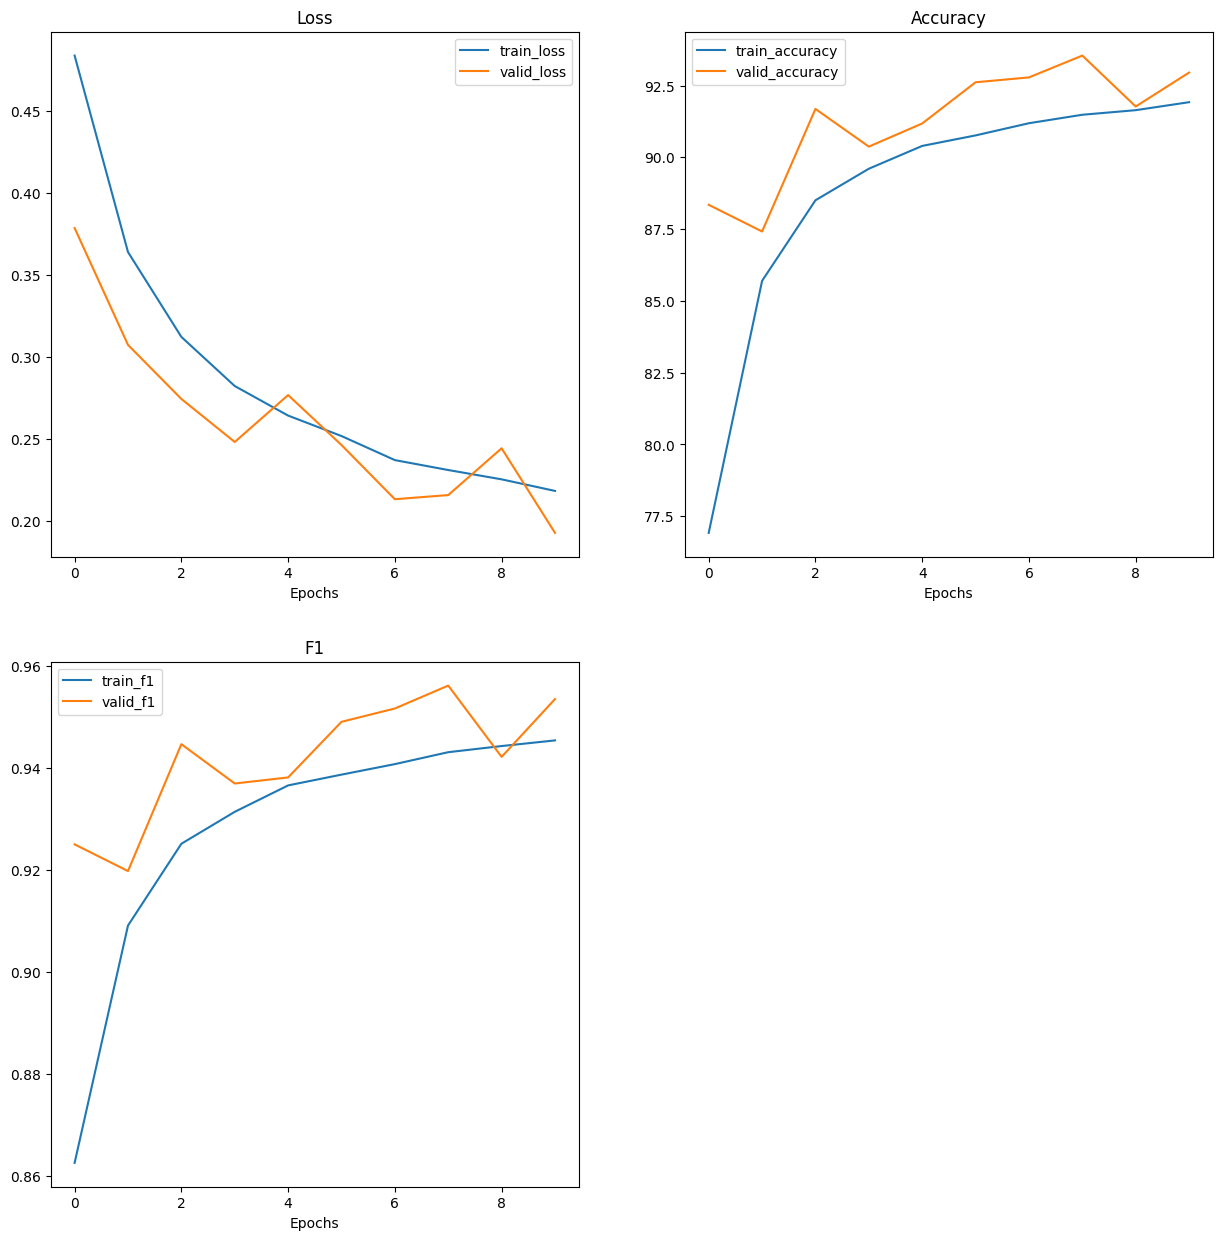

In [ ]:
#Linear layers 2
plot_loss_curves(model_0_results)

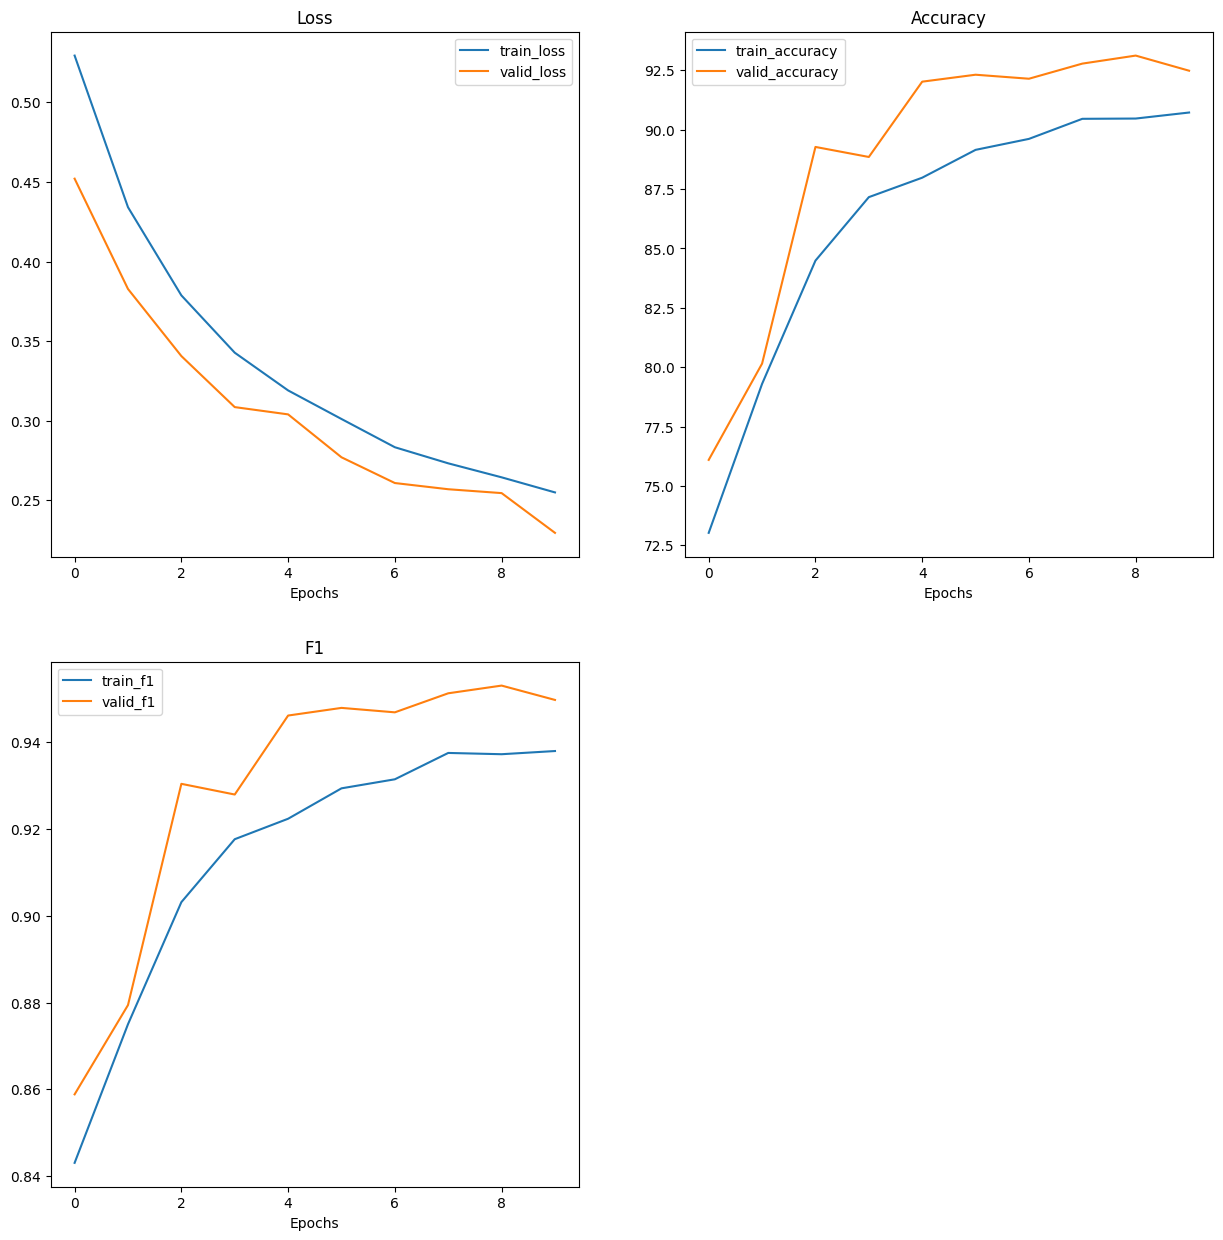

In [ ]:
# Linear layers: 3
plot_loss_curves(model_1_results)

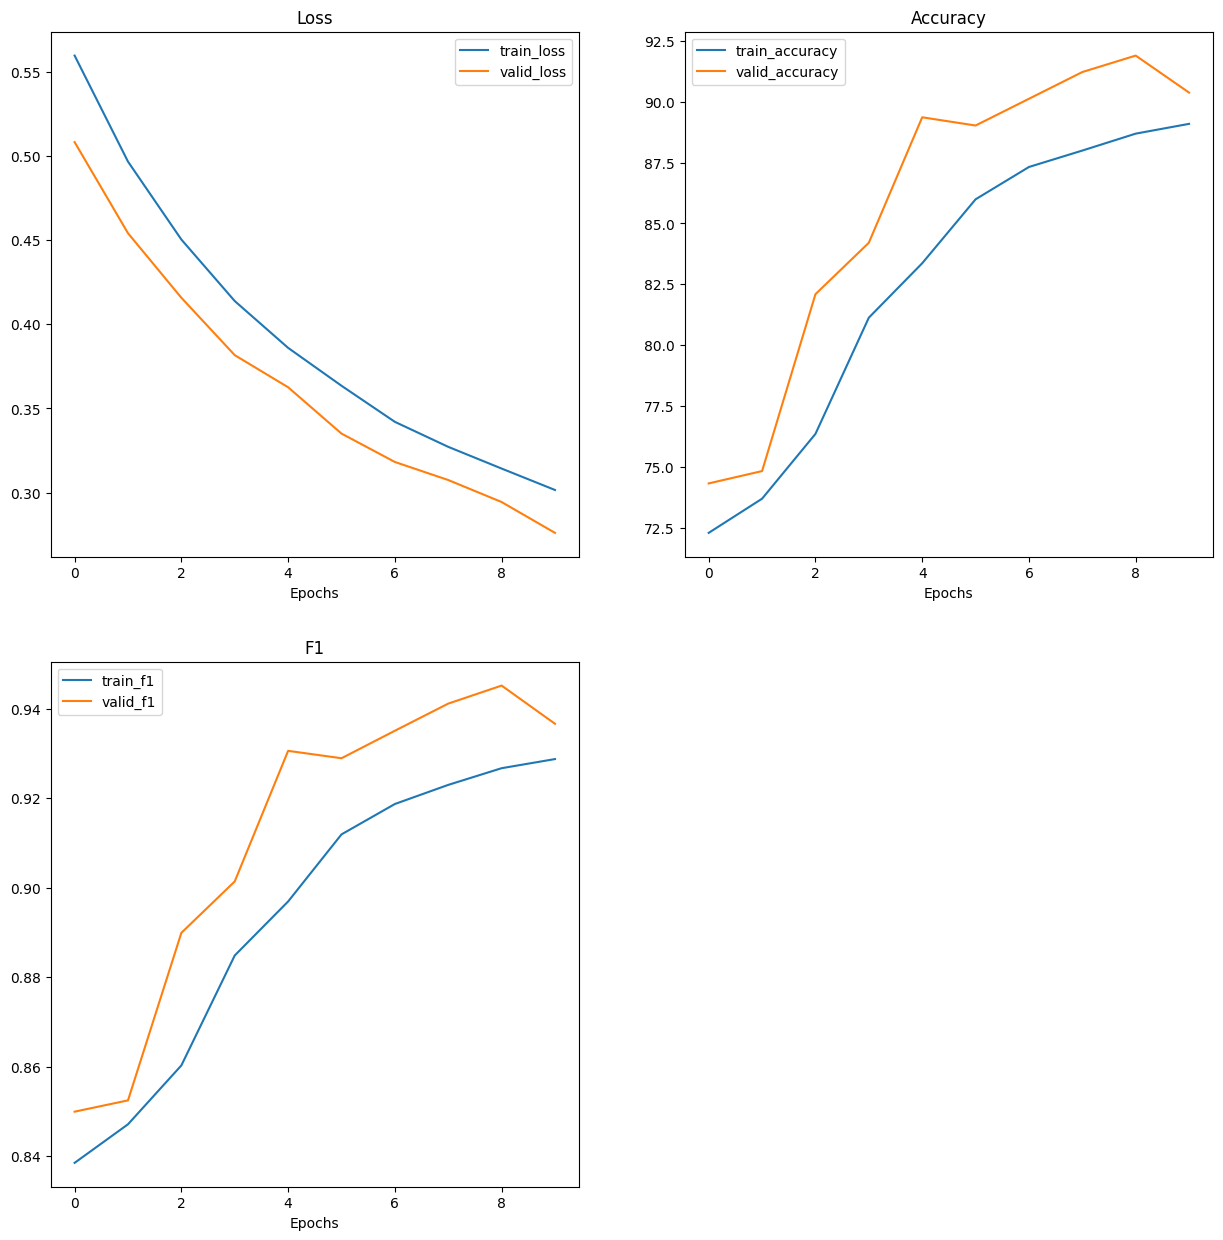

In [ ]:
# Linear layers: 4
plot_loss_curves(model_2_results)

***
### b. Linear models - Changing number of **hidden units**
***

#### Setting up models

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5

torch.manual_seed(42)

model_3 = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_3.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_3 = torch.optim.SGD(params=model_3.parameters(), lr=0.0001)

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20

torch.manual_seed(42)

model_4 = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=20, # how many units in the hidden layer
    output_shape=1
)
model_4.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_4 = torch.optim.SGD(params=model_4.parameters(), lr=0.0001)

***
#### Training
***

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train model
model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_3,
                        loss_fn=loss_fn, #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.51370 | Train accuracy: 73.76% | Train F1: 0.85
Validation loss: 0.42520 | Validation accuracy: 79.22%
 | Validation F1: 0.87
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.40729 | Train accuracy: 82.18% | Train F1: 0.89
Validation loss: 0.35402 | Validation accuracy: 83.19%
 | Validation F1: 0.90
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.35201 | Train accuracy: 86.45% | Train F1: 0.91
Validation loss: 0.31346 | Validation accuracy: 90.29%
 | Validation F1: 0.94
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.31810 | Train accuracy: 88.23% | Train F1: 0.92
Valida

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train model
model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_4,
                        loss_fn=loss_fn,  #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.50045 | Train accuracy: 74.81% | Train F1: 0.85
Validation loss: 0.40817 | Validation accuracy: 81.84%
 | Validation F1: 0.89
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.39231 | Train accuracy: 83.57% | Train F1: 0.90
Validation loss: 0.33876 | Validation accuracy: 84.29%
 | Validation F1: 0.90
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.33857 | Train accuracy: 87.36% | Train F1: 0.92
Validation loss: 0.30049 | Validation accuracy: 90.88%
 | Validation F1: 0.94
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.30617 | Train accuracy: 88.82% | Train F1: 0.93
Valida

***
#### Results
***

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5

model_3_results

{'train_loss': [0.5136997879017144,
  0.40729337581433356,
  0.35201150667853653,
  0.3180954159470275,
  0.2966207704739645,
  0.2807656801305711,
  0.26438677520491183,
  0.2559631019830704,
  0.24845998582895845,
  0.24004542012698948],
 'train_acc': [73.75863882211539,
  82.1796123798077,
  86.4520733173077,
  88.2342998798077,
  89.12635216346153,
  89.76111778846153,
  90.22310697115384,
  91.05506310096153,
  90.88416466346153,
  91.2841796875],
 'train_f1': [0.8468261928643072,
  0.8901646774437225,
  0.9137500000000001,
  0.9235922794704099,
  0.9290426387771521,
  0.9327935222672064,
  0.9350902879453391,
  0.9409268929503917,
  0.939617083946981,
  0.9414850024586134],
 'valid_loss': [0.4251968735778654,
  0.35402205143425913,
  0.31346043662444967,
  0.28370500396232345,
  0.28872270157208313,
  0.26079080112882563,
  0.2414841619697777,
  0.24033346369459824,
  0.24537632272050186,
  0.21450191736221313],
 'valid_acc': [79.22297297297297,
  83.19256756756756,
  90.28716216

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20

model_4_results

{'train_loss': [0.5004522248636931,
  0.392313486430794,
  0.3385650439886376,
  0.3061748683685437,
  0.2859716782113537,
  0.2711779947858304,
  0.25536030868534,
  0.24763796699699014,
  0.24075438641011715,
  0.23277037689695135],
 'train_acc': [74.80844350961539,
  83.5712139423077,
  87.3553936298077,
  88.8202373798077,
  89.46814903846153,
  90.22498497596153,
  90.61373197115384,
  91.4325420673077,
  91.20154747596153,
  91.6015625],
 'train_f1': [0.8523316062176165,
  0.8974594429139885,
  0.9188081349519155,
  0.9268841394825647,
  0.9309620048504448,
  0.9356725146198831,
  0.9375101974220917,
  0.9431000654022237,
  0.9416010498687665,
  0.9434954007884363],
 'valid_loss': [0.4081653682766734,
  0.3387556152569281,
  0.3004924868409698,
  0.2719273927646714,
  0.28293479656850967,
  0.2553296749656265,
  0.23266288094423912,
  0.232846942302343,
  0.2436322481245608,
  0.2073330824842324],
 'valid_acc': [81.84121621621621,
  84.29054054054055,
  90.87837837837837,
  90.03

***
#### Graphs
***

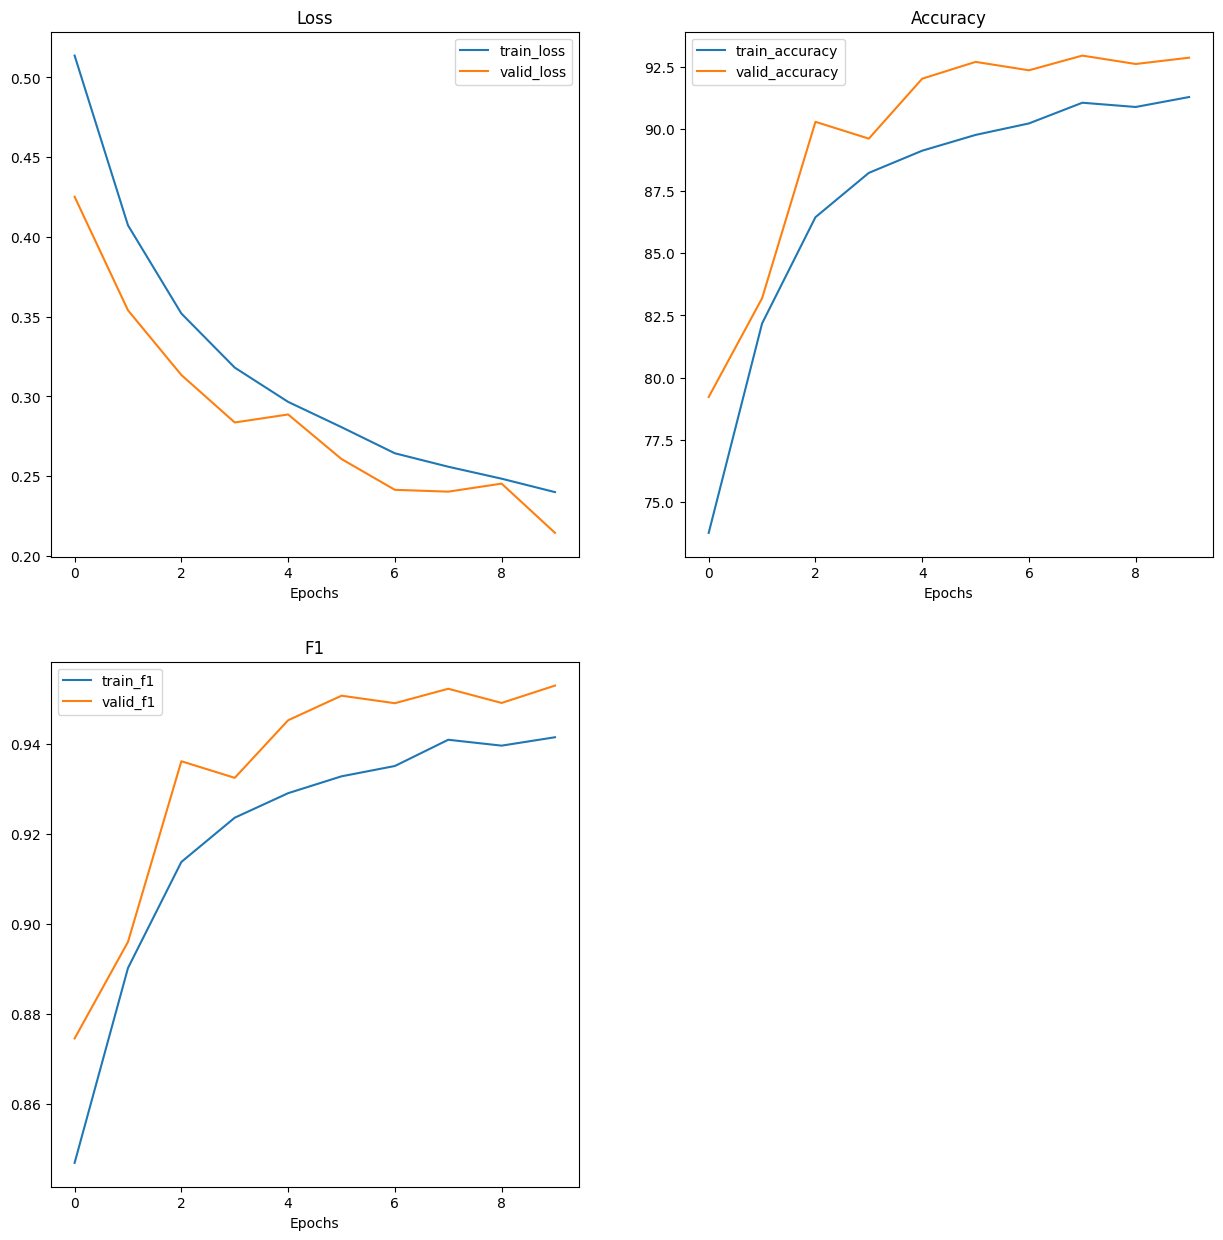

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5
plot_loss_curves(model_3_results)

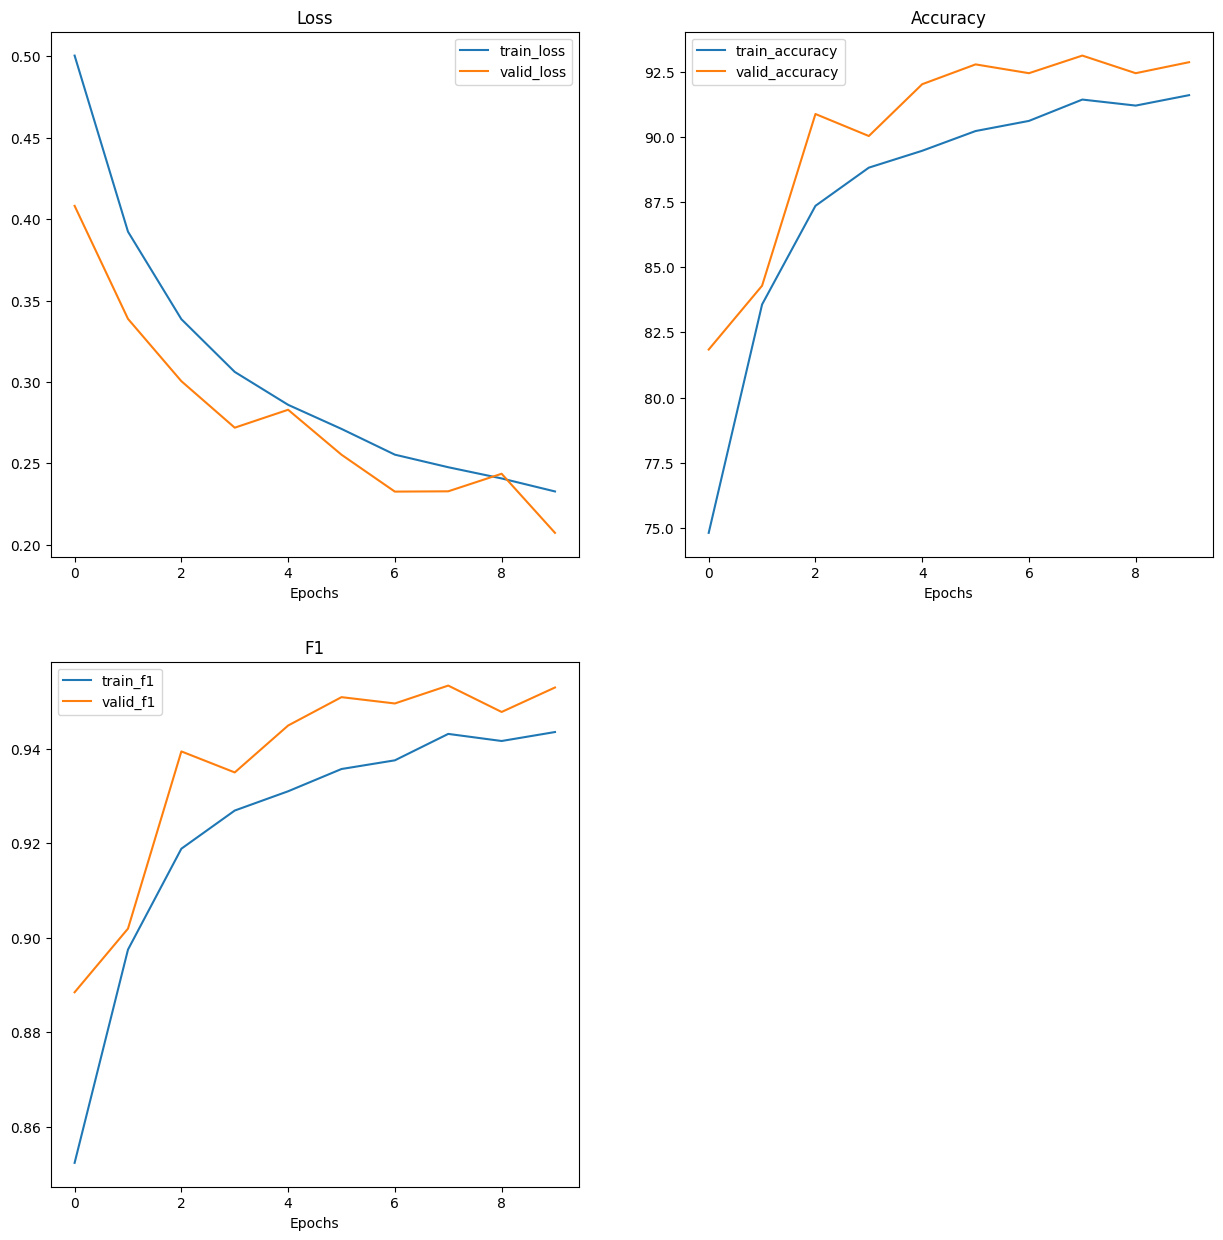

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20
plot_loss_curves(model_4_results)

***
### c. Linear+ReLU - Changing number of **layers**
***

#### Setting up models

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 10

torch.manual_seed(42)

model_5 = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_5.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [ ]:
optimizer_5 = torch.optim.SGD(params=model_5.parameters(), lr=0.0001)

In [ ]:
#Number of linear layers: 3
#Number of hidden units: 10

torch.manual_seed(42)

model_6 = XRAYS_linear3ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_6.to(device)

XRAYS_linear3ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=1, bias=True)
    (6): ReLU()
  )
)

In [ ]:
optimizer_6 = torch.optim.SGD(params=model_6.parameters(), lr=0.0001)

In [ ]:
#Number of linear layers: 4
#Number of hidden units: 10

torch.manual_seed(42)

model_7 = XRAYS_linear4ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_7.to(device)

XRAYS_linear4ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): ReLU()
    (7): Linear(in_features=10, out_features=1, bias=True)
    (8): ReLU()
  )
)

In [ ]:
optimizer_7 = torch.optim.SGD(params=model_7.parameters(), lr=0.0001)

***
#### Training
***

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of linear layers: 2
#Number of hidden units: 10

# Train model
model_5_results = train(model=model_5,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_5,
                        loss_fn=loss_fn, #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.52649 | Train accuracy: 73.39% | Train F1: 0.85
Validation loss: 0.44584 | Validation accuracy: 77.20%
 | Validation F1: 0.86
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.43642 | Train accuracy: 77.98% | Train F1: 0.87
Validation loss: 0.39152 | Validation accuracy: 78.46%
 | Validation F1: 0.87
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.39955 | Train accuracy: 81.51% | Train F1: 0.89
Validation loss: 0.36549 | Validation accuracy: 86.06%
 | Validation F1: 0.91
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37742 | Train accuracy: 83.40% | Train F1: 0.90
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of linear layers: 3
#Number of hidden units: 10

# Train model
model_6_results = train(model=model_6,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_6,
                        loss_fn=loss_fn, #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.69315 | Train accuracy: 27.10% | Train F1: 0.00
Validation loss: 0.69315 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.69315 | Train accuracy: 27.06% | Train F1: 0.00
Validation loss: 0.69315 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.69315 | Train accuracy: 27.13% | Train F1: 0.00
Validation loss: 0.69315 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.69315 | Train accuracy: 27.06% | Train F1: 0.00
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of linear layers: 4
#Number of hidden units: 10

# Train model
model_7_results = train(model=model_7,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_7,
                        loss_fn=loss_fn,  #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.69315 | Train accuracy: 27.10% | Train F1: 0.00
Validation loss: 0.69315 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.69315 | Train accuracy: 27.06% | Train F1: 0.00
Validation loss: 0.69315 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.69315 | Train accuracy: 27.13% | Train F1: 0.00
Validation loss: 0.69315 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.69315 | Train accuracy: 27.06% | Train F1: 0.00
Valida

***
#### Results
***

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 10

model_5_results

{'train_loss': [0.5264910561963916,
  0.4364248439669609,
  0.3995487157953903,
  0.37741961574647576,
  0.3638768255477771,
  0.35329308337531984,
  0.3421025611460209,
  0.3381916257785633,
  0.33292692387476563,
  0.3285857253940776],
 'train_acc': [73.39242788461539,
  77.9803936298077,
  81.50916466346153,
  83.4003155048077,
  84.65857872596153,
  85.69711538461539,
  86.95162259615384,
  87.34412560096153,
  87.85682091346153,
  88.36763822115384],
 'train_f1': [0.8457598178713716,
  0.8682783882783882,
  0.8872248015575858,
  0.897190584662111,
  0.9044117647058822,
  0.9103000309310239,
  0.9171459661122339,
  0.9197376639600251,
  0.9226909204955308,
  0.9251850685147267],
 'valid_loss': [0.44584138328964645,
  0.3915248082296268,
  0.3654880749212729,
  0.34622614609228597,
  0.36611395268826874,
  0.3478467391954886,
  0.31656054004624085,
  0.32507812413009435,
  0.3393301025435731,
  0.30234762563093287],
 'valid_acc': [77.19594594594595,
  78.46283783783784,
  86.0641891

In [ ]:
#Number of linear layers: 3
#Number of hidden units: 10

model_6_results

{'train_loss': [0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609],
 'train_acc': [27.095853365384617,
  27.06017127403846,
  27.13153545673077,
  27.06017127403846,
  27.06017127403846,
  27.095853365384617,
  27.06017127403846,
  27.095853365384617,
  27.095853365384617,
  27.095853365384617],
 'train_f1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'valid_loss': [0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536],
 'valid_acc': [25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677],
 'valid_f1':

In [ ]:
#Number of linear layers: 4
#Number of hidden units: 10

model_7_results

{'train_loss': [0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609,
  0.6931471829302609],
 'train_acc': [27.095853365384617,
  27.06017127403846,
  27.13153545673077,
  27.06017127403846,
  27.06017127403846,
  27.095853365384617,
  27.06017127403846,
  27.095853365384617,
  27.095853365384617,
  27.095853365384617],
 'train_f1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'valid_loss': [0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536,
  0.693147184075536],
 'valid_acc': [25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677],
 'valid_f1':

***
#### Graphs
***

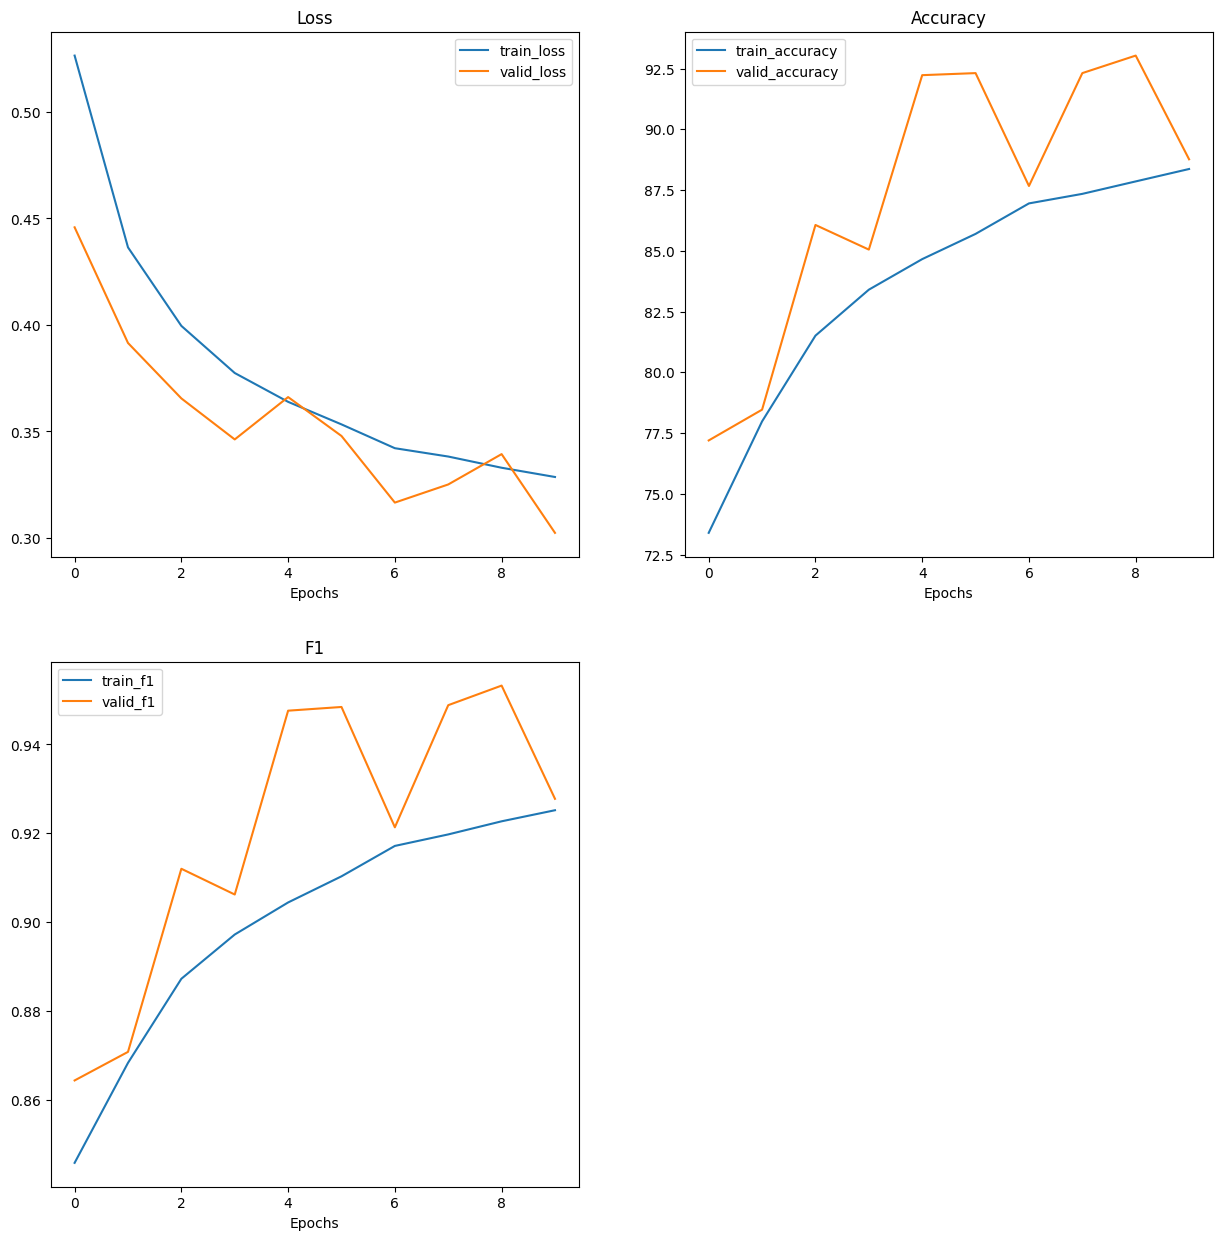

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 10

plot_loss_curves(model_5_results)

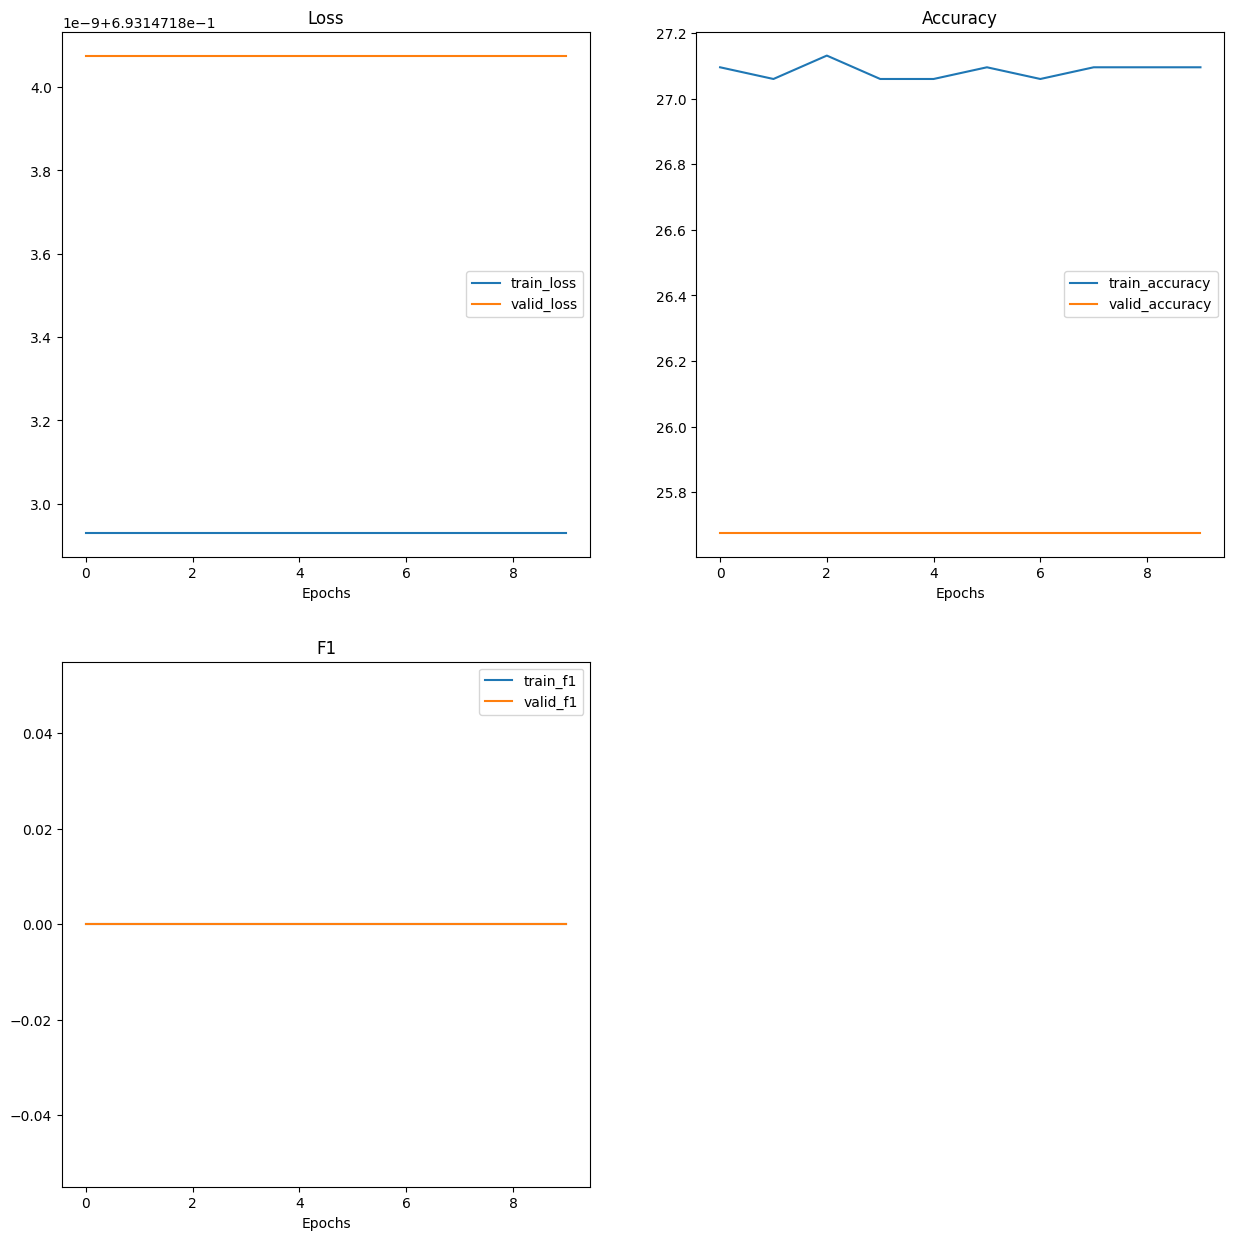

In [ ]:
#Number of linear layers: 3
#Number of hidden units: 10

plot_loss_curves(model_6_results)

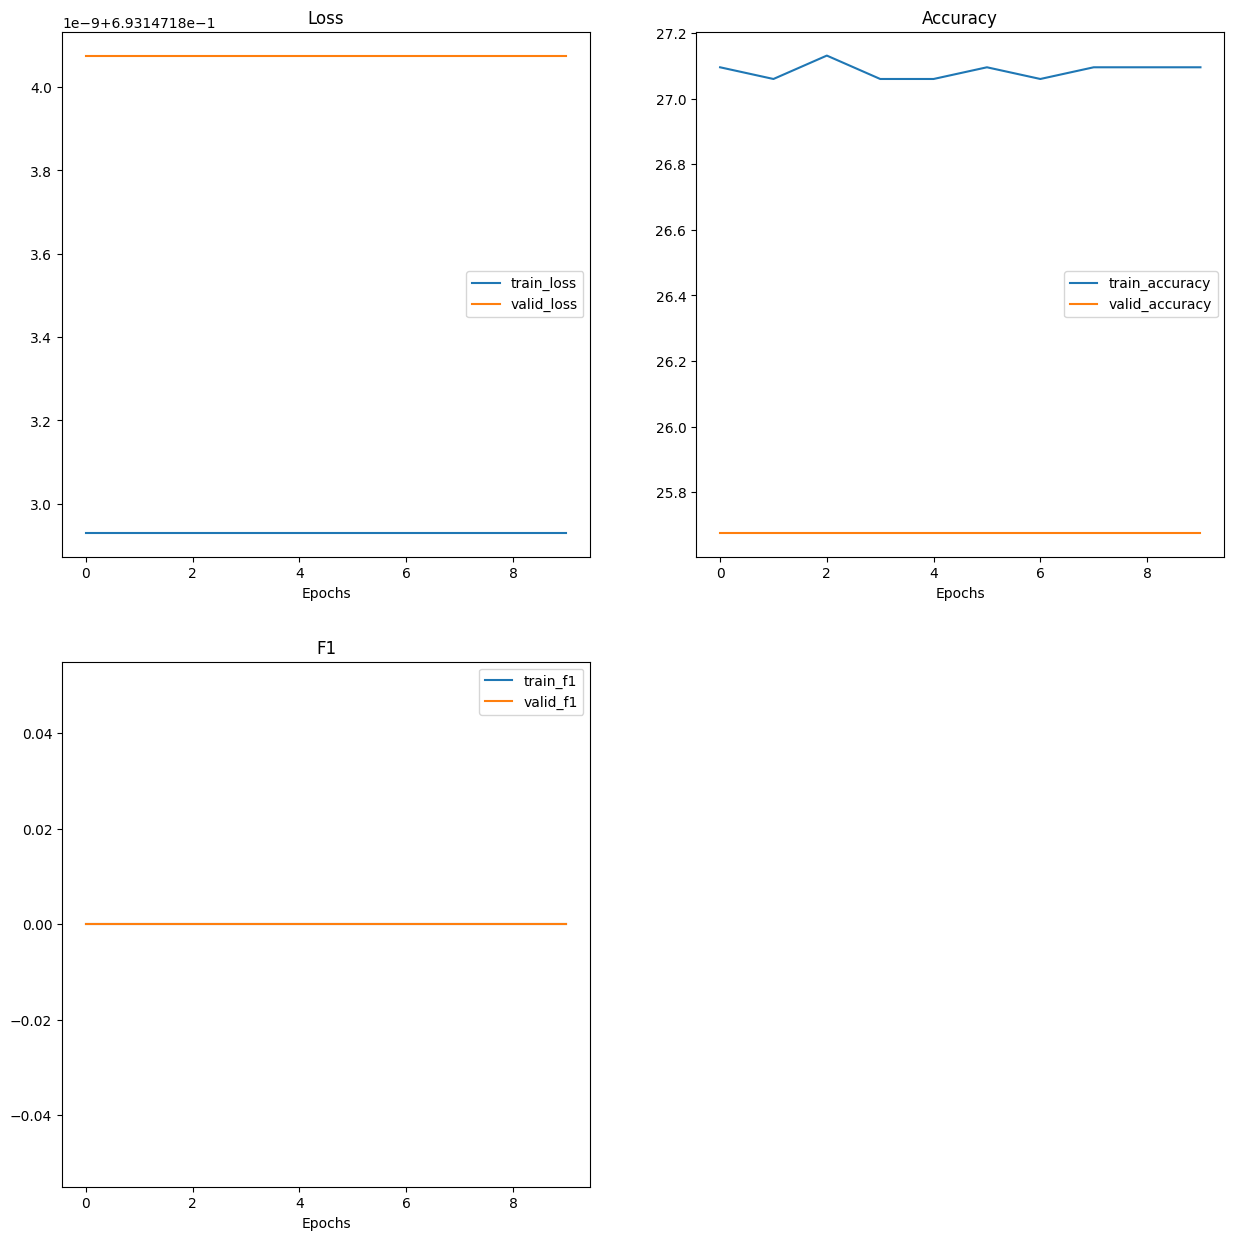

In [ ]:
#Number of linear layers: 4
#Number of hidden units: 10

plot_loss_curves(model_7_results)

***
### d. Linear+ReLU - Changing number of **hidden units**

#### Setting up models

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5

torch.manual_seed(42)

model_8 = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_8.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=5, bias=True)
    (2): ReLU()
    (3): Linear(in_features=5, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [ ]:
optimizer_8 = torch.optim.SGD(params=model_8.parameters(), lr=0.0001)

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20

torch.manual_seed(42)

model_9 = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=20, # how many units in the hidden layer
    output_shape=1
)
model_9.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [ ]:
optimizer_9 = torch.optim.SGD(params=model_9.parameters(), lr=0.0001)

#### Training

In [ ]:
#Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of linear layers: 2
#Number of hidden units: 5

# Train model
model_8_results = train(model=model_8,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_8,
                        loss_fn=loss_fn, #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.57099 | Train accuracy: 72.90% | Train F1: 0.84
Validation loss: 0.53730 | Validation accuracy: 74.32%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.53525 | Train accuracy: 72.94% | Train F1: 0.84
Validation loss: 0.50424 | Validation accuracy: 74.32%
 | Validation F1: 0.85
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.50566 | Train accuracy: 72.87% | Train F1: 0.84
Validation loss: 0.47692 | Validation accuracy: 74.32%
 | Validation F1: 0.85
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.47995 | Train accuracy: 72.94% | Train F1: 0.84
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of linear layers: 2
#Number of hidden units: 20

# Train model
model_9_results = train(model=model_9,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_9,
                        loss_fn=loss_fn, #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.55578 | Train accuracy: 72.90% | Train F1: 0.84
Validation loss: 0.50198 | Validation accuracy: 74.32%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.48852 | Train accuracy: 73.31% | Train F1: 0.85
Validation loss: 0.44413 | Validation accuracy: 74.75%
 | Validation F1: 0.85
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.44347 | Train accuracy: 75.72% | Train F1: 0.86
Validation loss: 0.40880 | Validation accuracy: 79.22%
 | Validation F1: 0.87
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.41616 | Train accuracy: 79.05% | Train F1: 0.87
Valida

#### Results

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5
model_8_results

{'train_loss': [0.5709852061700076,
  0.5352476791013032,
  0.5056563508696854,
  0.4799545081332326,
  0.4604949033819139,
  0.44530480867251754,
  0.4313159075099975,
  0.4216925335349515,
  0.41320301534142345,
  0.40492586442269385],
 'train_acc': [72.90414663461539,
  72.93982872596153,
  72.86846454326923,
  72.93982872596153,
  72.93982872596153,
  72.90414663461539,
  72.93982872596153,
  72.90414663461539,
  72.90414663461539,
  72.90414663461539],
 'train_f1': [0.8434042553191489,
  0.8434042553191489,
  0.8434042553191489,
  0.8434042553191489,
  0.8434042553191489,
  0.8434042553191489,
  0.8434042553191489,
  0.8434042553191489,
  0.8434042553191489,
  0.8434042553191489],
 'valid_loss': [0.537304597126471,
  0.5042440834883097,
  0.4769156462437398,
  0.45373670313809367,
  0.43803590254203695,
  0.4202192236442824,
  0.40870928562976216,
  0.40178928383298823,
  0.394121737899007,
  0.38119826365161585],
 'valid_acc': [74.32432432432432,
  74.32432432432432,
  74.3243243

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20
model_9_results

{'train_loss': [0.5557779150549322,
  0.488522649044171,
  0.44347492535598576,
  0.41615648358128965,
  0.3994656653376296,
  0.38672916253563017,
  0.37437431141734123,
  0.3676690289285034,
  0.36159725685138255,
  0.3553213714621961],
 'train_acc': [72.90414663461539,
  73.30603966346153,
  75.72303185096153,
  79.0546123798077,
  80.87439903846153,
  82.37680288461539,
  83.2294170673077,
  84.12146935096153,
  84.85389122596153,
  85.5487530048077],
 'train_f1': [0.8434042553191489,
  0.8452025586353945,
  0.8571840738603577,
  0.8740980709762922,
  0.8839910647803426,
  0.8921361855980717,
  0.8964577656675751,
  0.9016143770941213,
  0.905666156202144,
  0.9093427735878098],
 'valid_loss': [0.5019839824856939,
  0.44413161358317815,
  0.40880240338879664,
  0.3864451336699563,
  0.38203445318582896,
  0.3627045227063669,
  0.3513022846466786,
  0.3487547764907012,
  0.34502401988248566,
  0.33081825842728485],
 'valid_acc': [74.32432432432432,
  74.74662162162163,
  79.22297297

#### Graphs

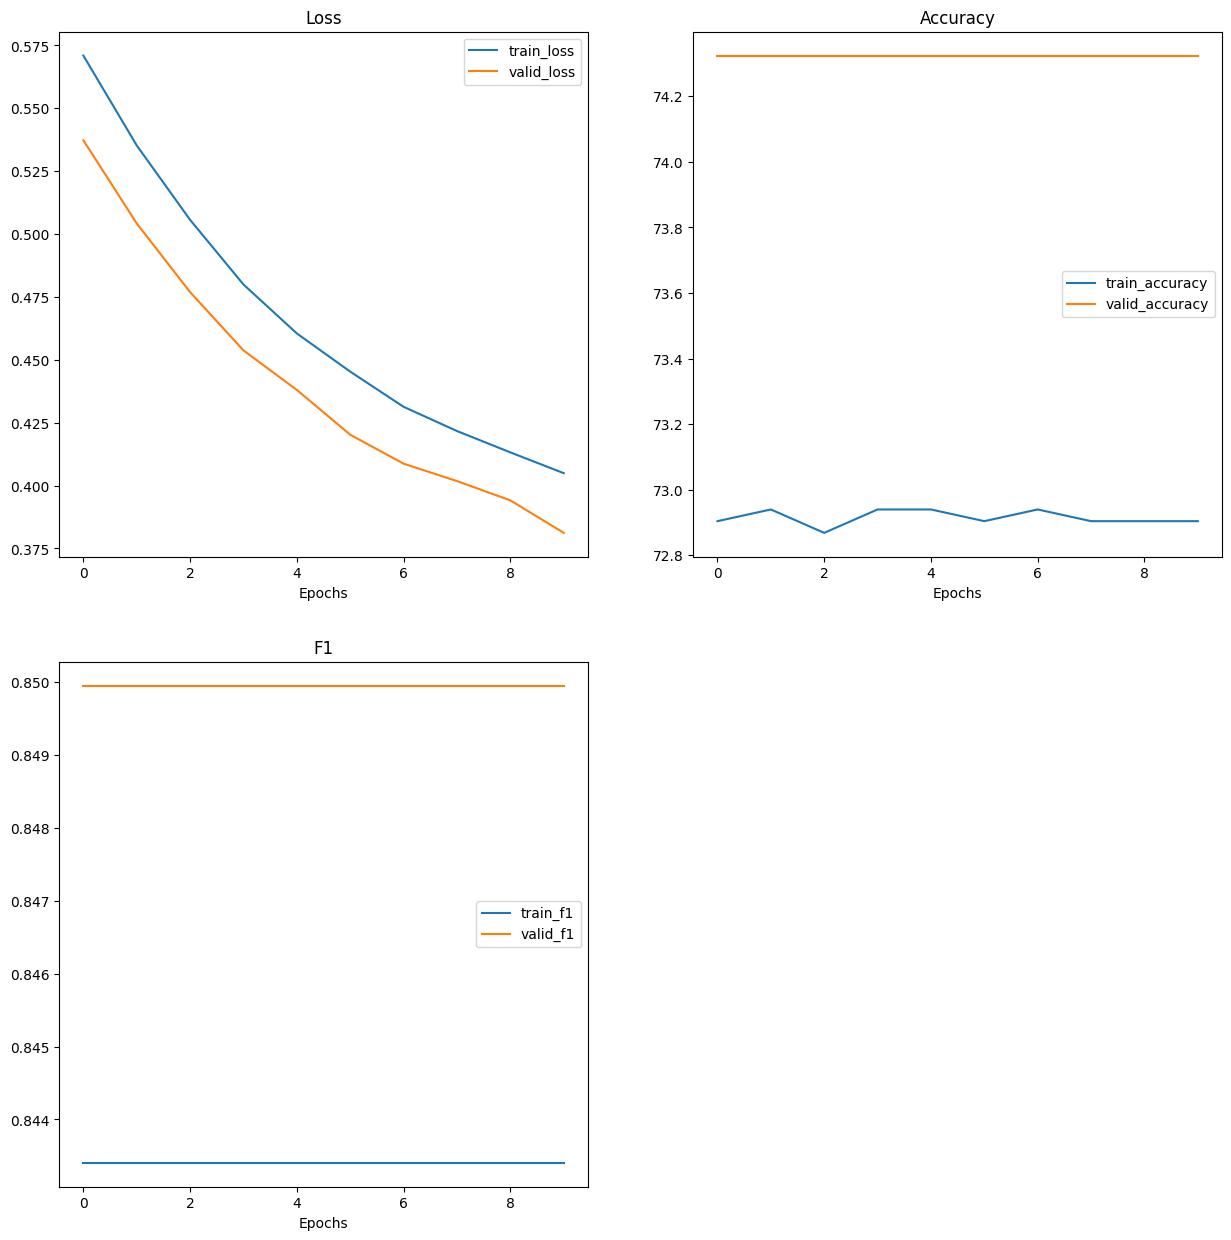

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5
plot_loss_curves(model_8_results)

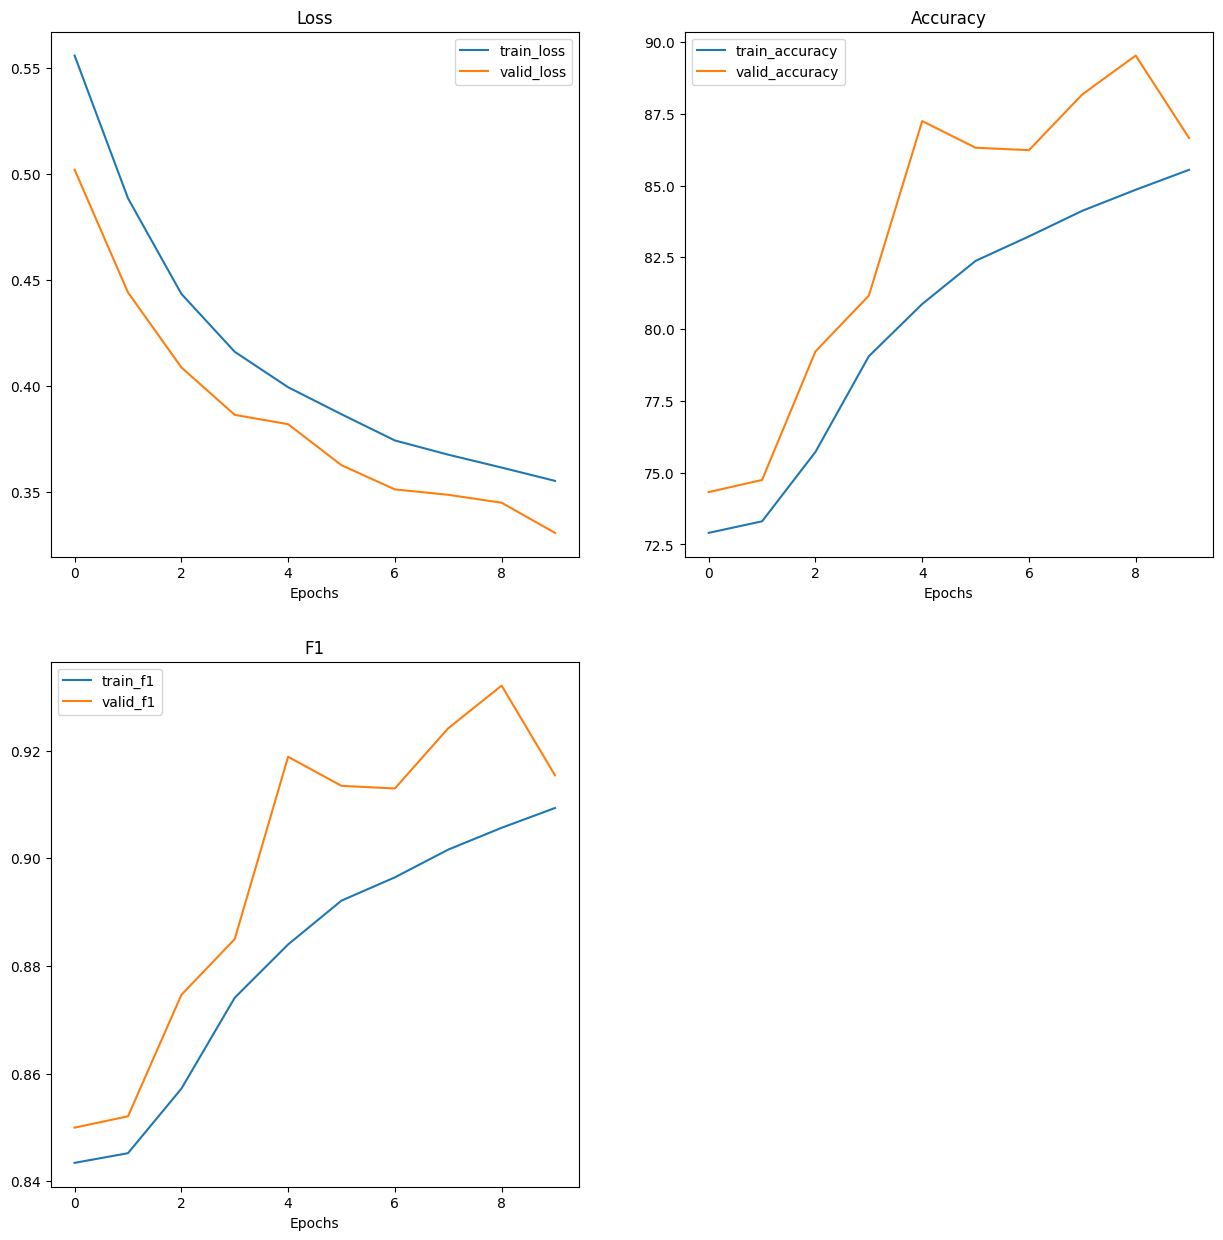

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20
plot_loss_curves(model_9_results)

***
### e. CNN - 1 L.L. - Changing number of **hidden units**
***

#### Setting up model

In [ ]:
#Number of linear layers: 1
#Number of hidden units: 5

torch.manual_seed(42)

model_10 = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_10.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_10 = torch.optim.SGD(params=model_10.parameters(), lr=0.01)  #learning rate had to be increased for convergence

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 10

torch.manual_seed(42)

model_11 = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_11.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256000, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_11 = torch.optim.SGD(params=model_11.parameters(), lr=0.01)

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20

torch.manual_seed(42)

model_12 = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=20, # how many units in the hidden layer
    output_shape=1
)
model_12.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512000, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_12 = torch.optim.SGD(params=model_12.parameters(), lr=0.01)

#### Training

In [ ]:
#Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of linear layers: 2
#Number of hidden units: 5

# Train model
model_10_results = train(model=model_10,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_10,
                        loss_fn=loss_fn, #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.58477 | Train accuracy: 72.17% | Train F1: 0.84
Validation loss: 0.49315 | Validation accuracy: 74.41%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.35183 | Train accuracy: 85.05% | Train F1: 0.90
Validation loss: 0.24292 | Validation accuracy: 89.19%
 | Validation F1: 0.93
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.26186 | Train accuracy: 89.76% | Train F1: 0.93
Validation loss: 0.19934 | Validation accuracy: 92.95%
 | Validation F1: 0.95
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.22067 | Train accuracy: 91.19% | Train F1: 0.94
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of linear layers: 2
#Number of hidden units: 10

# Train model
model_11_results = train(model=model_11,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_11,
                        loss_fn=loss_fn, #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.55099 | Train accuracy: 73.86% | Train F1: 0.84
Validation loss: 0.42527 | Validation accuracy: 85.39%
 | Validation F1: 0.91
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.28218 | Train accuracy: 88.32% | Train F1: 0.92
Validation loss: 0.17512 | Validation accuracy: 93.41%
 | Validation F1: 0.96
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.21577 | Train accuracy: 91.33% | Train F1: 0.94
Validation loss: 0.15342 | Validation accuracy: 93.63%
 | Validation F1: 0.96
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.18656 | Train accuracy: 92.91% | Train F1: 0.95
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Number of linear layers: 2
#Number of hidden units: 20

# Train model
model_12_results = train(model=model_12,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_12,
                        loss_fn=loss_fn, #no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.53765 | Train accuracy: 74.70% | Train F1: 0.85
Validation loss: 0.32320 | Validation accuracy: 90.59%
 | Validation F1: 0.94
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.34925 | Train accuracy: 85.93% | Train F1: 0.91
Validation loss: 0.20773 | Validation accuracy: 92.82%
 | Validation F1: 0.95
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.21831 | Train accuracy: 91.28% | Train F1: 0.94
Validation loss: 0.14486 | Validation accuracy: 93.88%
 | Validation F1: 0.96
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.18573 | Train accuracy: 93.07% | Train F1: 0.95
Valida

#### Results

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5
model_10_results

{'train_loss': [0.5847746138460934,
  0.35182939207879826,
  0.26186220854287967,
  0.2206718459201511,
  0.2197556899918709,
  0.22069312789244577,
  0.19824161630822346,
  0.1930031623924151,
  0.19357694787322544,
  0.1790921752108261],
 'train_acc': [72.17172475961539,
  85.04732572115384,
  89.75923978365384,
  91.1884014423077,
  91.0663311298077,
  90.70199819711539,
  91.8701171875,
  92.29830228365384,
  92.17623197115384,
  93.3349609375],
 'train_f1': [0.8376753507014029,
  0.9024740622505987,
  0.9304955104755571,
  0.9403730846102598,
  0.9396107136915653,
  0.9374269981645252,
  0.9443980631157123,
  0.9477015323117922,
  0.9468244707451242,
  0.9544924154025671],
 'valid_loss': [0.49314999822023753,
  0.24291592398406686,
  0.19933849754365715,
  0.2088039077163951,
  0.4059513149833357,
  0.38531493566728925,
  0.16144416612145063,
  0.18289165138392835,
  0.23713599105139035,
  0.16798474672376304],
 'valid_acc': [74.40878378378379,
  89.1891891891892,
  92.95088357588

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 10
model_11_results

{'train_loss': [0.5509923857171088,
  0.2821815560455434,
  0.21577381290262565,
  0.1865561586455442,
  0.1738147417199798,
  0.17161406693048775,
  0.15497113172750687,
  0.15000685334962327,
  0.14678058402932948,
  0.1485831692116335],
 'train_acc': [73.85629507211539,
  88.31881009615384,
  91.3330078125,
  92.91053185096153,
  93.4833233173077,
  93.3856670673077,
  94.1162109375,
  94.2401592548077,
  94.37349759615384,
  94.384765625],
 'train_f1': [0.84427547887118,
  0.9221224489795918,
  0.9409416070537346,
  0.952253756260434,
  0.9559412550066756,
  0.9553035356904602,
  0.9597192044125021,
  0.9612119194273347,
  0.9617504593285453,
  0.9614998326079678],
 'valid_loss': [0.42526638185655746,
  0.17511704780564114,
  0.15342194677607432,
  0.16491638020788496,
  0.25973452909572703,
  0.23465843458433408,
  0.12378252400840456,
  0.14961152926490112,
  0.2976558931373261,
  0.12577920222050837],
 'valid_acc': [85.38851351351352,
  93.41216216216216,
  93.62655925155926,
  

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20
model_12_results

{'train_loss': [0.5376529144123197,
  0.34925408521667123,
  0.21830768801737577,
  0.18573407838994171,
  0.170696839762968,
  0.17421054732403718,
  0.15370594696287299,
  0.14914614148437977,
  0.14258698253252078,
  0.14296975360775832],
 'train_acc': [74.69576322115384,
  85.92623197115384,
  91.2841796875,
  93.0682842548077,
  93.5077373798077,
  93.4100811298077,
  94.3359375,
  94.2157451923077,
  94.6796123798077,
  94.6044921875],
 'train_f1': [0.8486178148310662,
  0.906183716756404,
  0.94049008168028,
  0.9530178899849523,
  0.9561301084236864,
  0.9554628857381151,
  0.9611780455153949,
  0.9609869956652217,
  0.9640888591949225,
  0.9630620090255725],
 'valid_loss': [0.3231967735934902,
  0.2077301692318272,
  0.144856546074152,
  0.1540216188877821,
  0.2707642402902648,
  0.21624213970593503,
  0.12042903953005334,
  0.14033077959273313,
  0.32471506478818685,
  0.13727266921636624],
 'valid_acc': [90.58601871101871,
  92.82094594594595,
  93.87993762993763,
  94.0488

#### Graphs

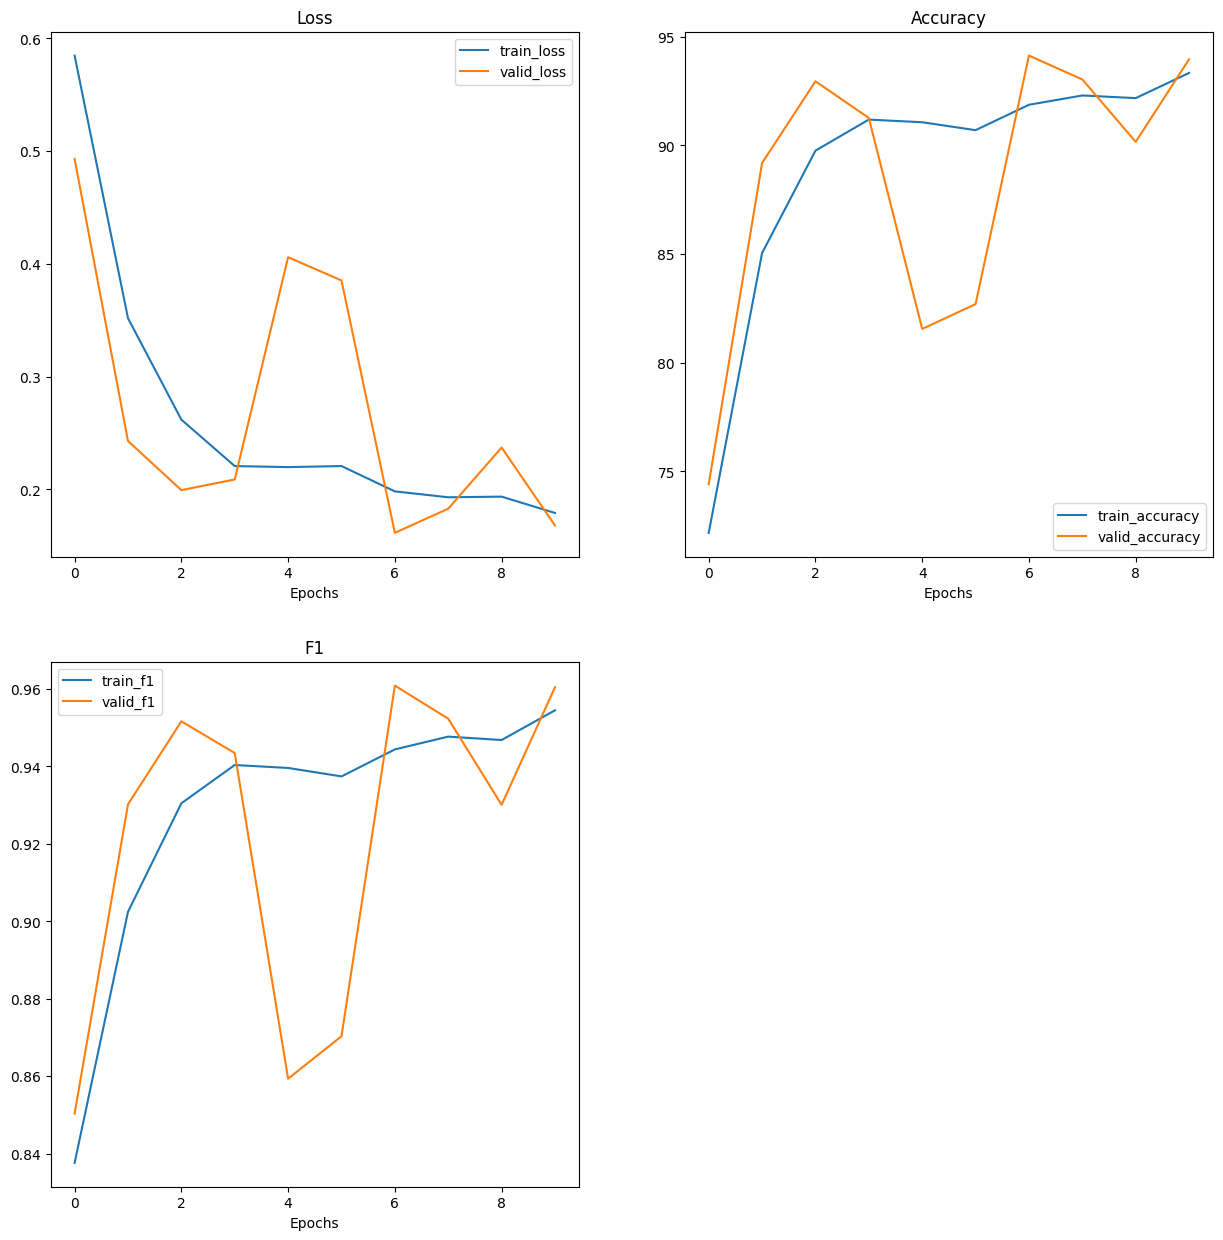

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 5
plot_loss_curves(model_10_results)

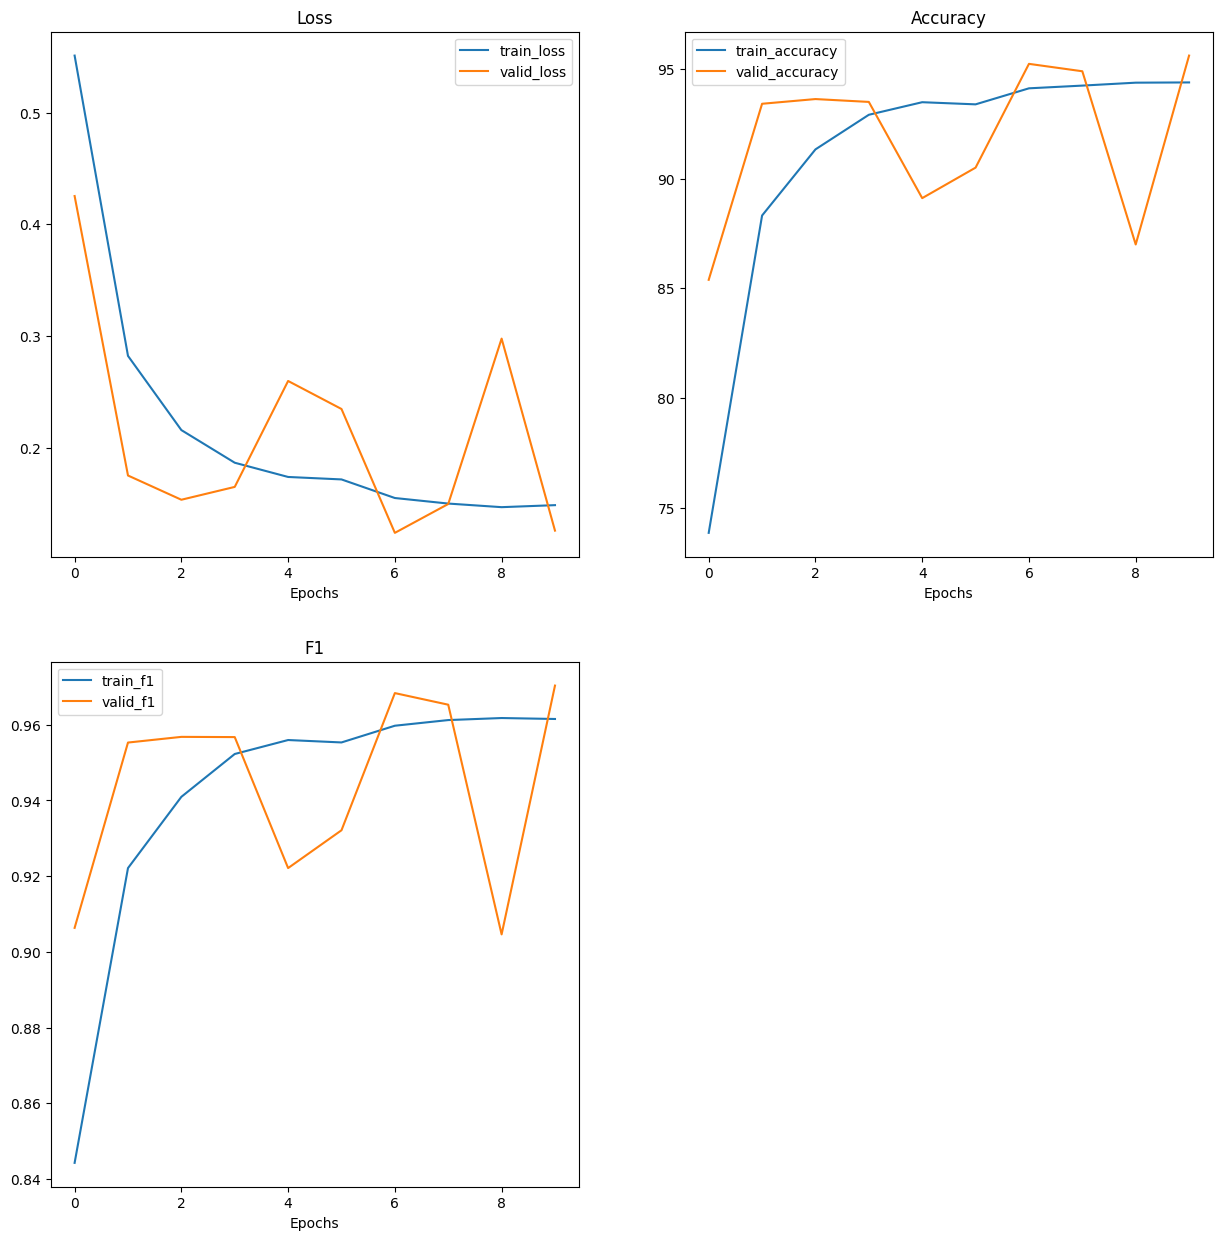

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 10
plot_loss_curves(model_11_results)

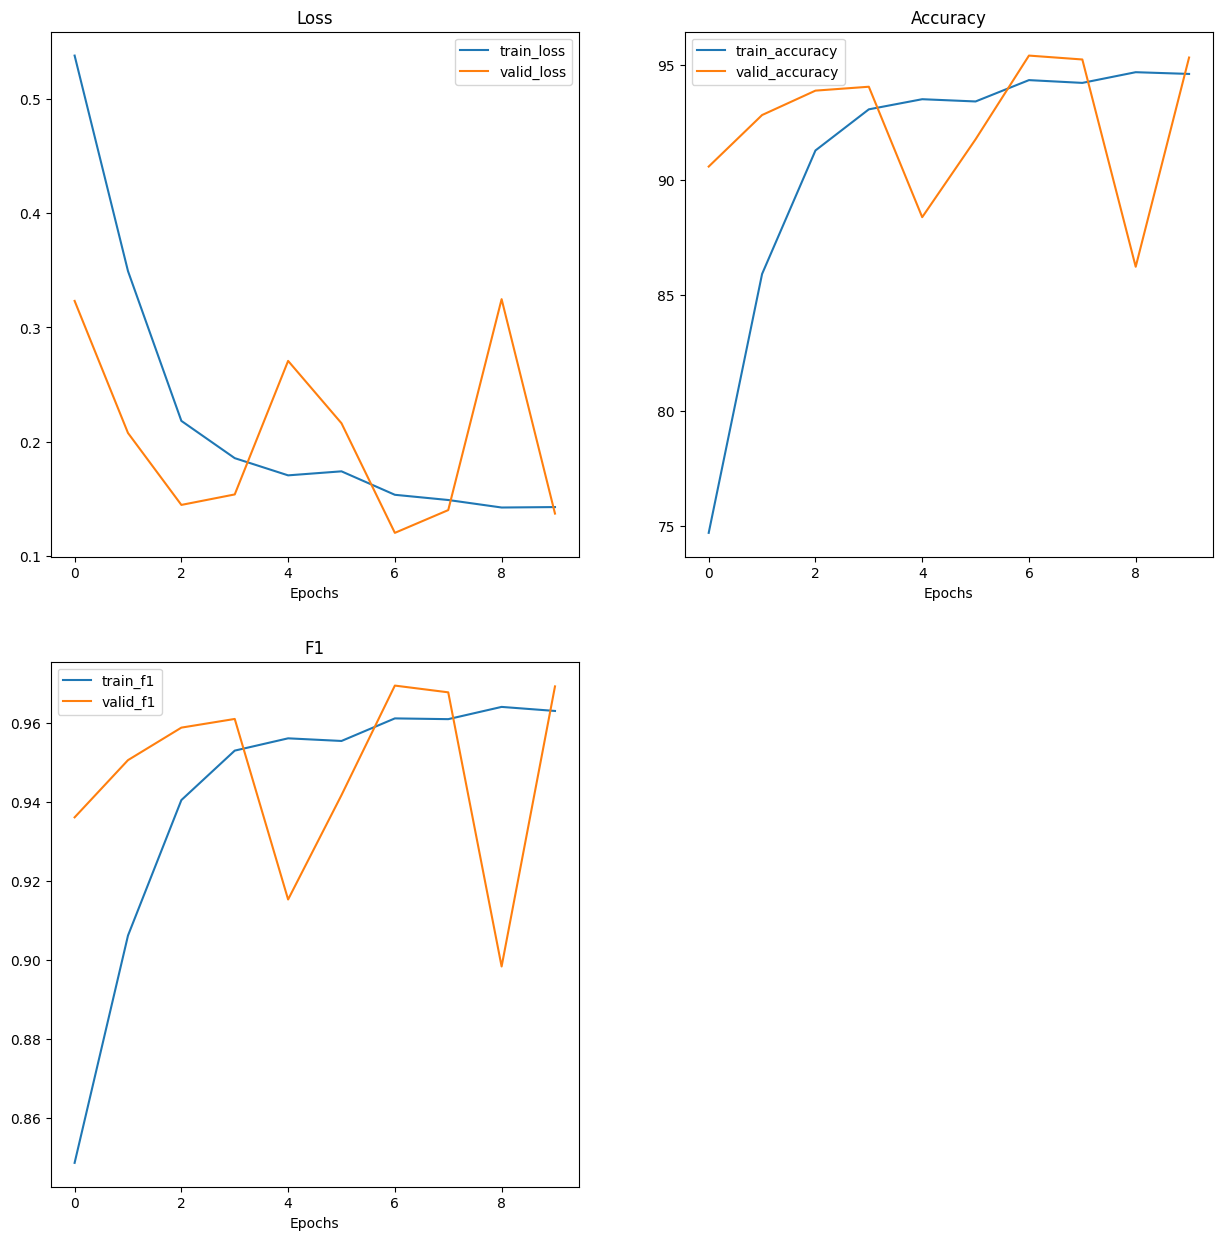

In [ ]:
#Number of linear layers: 2
#Number of hidden units: 20
plot_loss_curves(model_12_results)

### f. CNN - 2 L.L.

#### Setting up model

In [ ]:
# Number of linear layers: 2
# Number of hidden units: 5
torch.manual_seed(42)

model_13 = XRAYS_CNN2(input_shape=1, # 1 colour channel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_13.to(device)

XRAYS_CNN2(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_13 = torch.optim.SGD(params=model_13.parameters(), lr=0.01)

#### Training

In [ ]:
#Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 5

# Train model
model_13_results = train(model=model_13,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_13,
                        loss_fn=loss_fn, # no weight
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.58909 | Train accuracy: 72.90% | Train F1: 0.84
Validation loss: 0.55941 | Validation accuracy: 74.32%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.49356 | Train accuracy: 77.05% | Train F1: 0.86
Validation loss: 0.31502 | Validation accuracy: 85.39%
 | Validation F1: 0.91
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.28876 | Train accuracy: 88.15% | Train F1: 0.92
Validation loss: 0.20675 | Validation accuracy: 92.87%
 | Validation F1: 0.95
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.22879 | Train accuracy: 91.03% | Train F1: 0.94
Valida

#### Results

In [ ]:
# Number of linear layers: 2
# Number of hidden units: 5
model_13_results

{'train_loss': [0.5890887554269284,
  0.493556818459183,
  0.288761114992667,
  0.22879087342880666,
  0.22720588446827605,
  0.2277363269822672,
  0.20295797256403603,
  0.1983814843406435,
  0.20164330283296295,
  0.18603041071037296],
 'train_acc': [72.90414663461539,
  77.0526592548077,
  88.14791165865384,
  91.02877103365384,
  90.7489483173077,
  90.31137319711539,
  91.6259765625,
  91.98091947115384,
  91.85884915865384,
  92.7978515625],
 'train_f1': [0.8434042553191489,
  0.8627106227106227,
  0.9201583635763774,
  0.9391824526420737,
  0.9375,
  0.9349092725153987,
  0.9427665609878191,
  0.945581627558662,
  0.9447587354409318,
  0.9508742714404662],
 'valid_loss': [0.5594122353437785,
  0.3150200963624426,
  0.20675298712543538,
  0.2099085174802993,
  0.3995457437594195,
  0.37188965062031876,
  0.16462151776697184,
  0.19324089707554998,
  0.2425758599026783,
  0.1768488846970974],
 'valid_acc': [74.32432432432432,
  85.38851351351352,
  92.86642411642411,
  91.09277546

#### Graphs

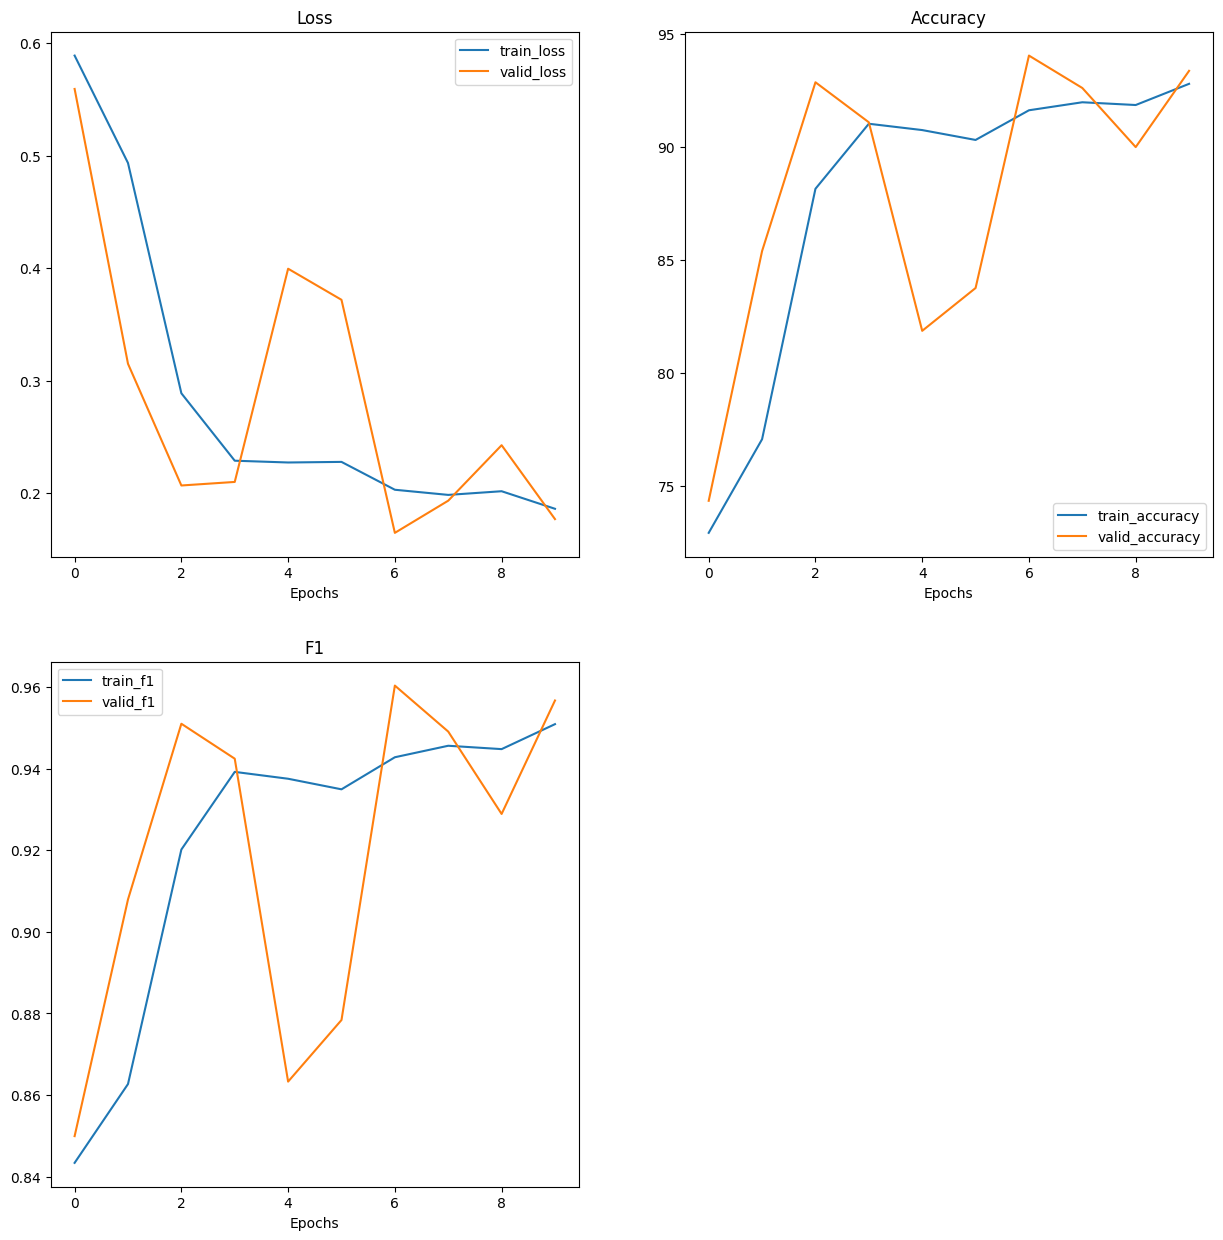

In [ ]:
# Number of linear layers: 2
# Number of hidden units: 5
plot_loss_curves(model_13_results)

***
### g. Using **weighed loss function**
***

#### Setting up models

In [ ]:
#Linear
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
model_14 = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_14.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_14 = torch.optim.SGD(params=model_14.parameters(), lr=0.0001)

In [ ]:
#Non-linear
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
model_15 = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_15.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [ ]:
optimizer_15 = torch.optim.SGD(params=model_15.parameters(), lr=0.0001)

In [ ]:
#CNN
torch.manual_seed(42)

# Number of linear layers: 1
# Number of hidden units: 5
model_16 = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_16.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_16 = torch.optim.SGD(params=model_16.parameters(), lr=0.01)

#### Training

In [ ]:
#Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Linear class
# Number of linear layers: 2
# Number of hidden units: 10
# Using weighed loss function
# Train model
model_14_results = train(model=model_14,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_14,
                        loss_fn=loss_fn_weighed, #adding pos_weight to account for class imbalance
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.32010 | Train accuracy: 72.17% | Train F1: 0.79
Validation loss: 0.26245 | Validation accuracy: 86.20%
 | Validation F1: 0.90
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.25142 | Train accuracy: 84.91% | Train F1: 0.89
Validation loss: 0.21744 | Validation accuracy: 90.50%
 | Validation F1: 0.93
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.21756 | Train accuracy: 86.65% | Train F1: 0.90
Validation loss: 0.19468 | Validation accuracy: 86.37%
 | Validation F1: 0.90
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.19684 | Train accuracy: 87.34% | Train F1: 0.91
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Using weighed loss function
# Train model
model_15_results = train(model=model_15,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_15,
                        loss_fn=loss_fn_weighed, #adding pos_weight to account for class imbalance
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.36493 | Train accuracy: 75.30% | Train F1: 0.85
Validation loss: 0.34063 | Validation accuracy: 86.40%
 | Validation F1: 0.91
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.33854 | Train accuracy: 81.59% | Train F1: 0.89
Validation loss: 0.31488 | Validation accuracy: 81.17%
 | Validation F1: 0.88
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.32160 | Train accuracy: 83.83% | Train F1: 0.90
Validation loss: 0.30421 | Validation accuracy: 89.95%
 | Validation F1: 0.93
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.30923 | Train accuracy: 85.49% | Train F1: 0.91
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Using weighed loss function
# Train model
model_16_results = train(model=model_16,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_16,
                        loss_fn=loss_fn_weighed, #adding pos_weight to account for class imbalance
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37826 | Train accuracy: 51.76% | Train F1: 0.61
Validation loss: 0.35432 | Validation accuracy: 74.94%
 | Validation F1: 0.80
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.29391 | Train accuracy: 81.06% | Train F1: 0.86
Validation loss: 0.19169 | Validation accuracy: 89.27%
 | Validation F1: 0.93
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.17120 | Train accuracy: 86.61% | Train F1: 0.90
Validation loss: 0.12421 | Validation accuracy: 88.69%
 | Validation F1: 0.92
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.13838 | Train accuracy: 88.83% | Train F1: 0.92
Valida

#### Results

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_14_results

{'train_loss': [0.320098091266118,
  0.25141966703813523,
  0.21756167279090732,
  0.19683810364222154,
  0.18425630178535357,
  0.17449697450501844,
  0.16454684047494084,
  0.1599989258684218,
  0.15519810345722362,
  0.1502494122250937],
 'train_acc': [72.16796875,
  84.9139873798077,
  86.64926382211539,
  87.34224759615384,
  88.2342998798077,
  88.4296123798077,
  88.8916015625,
  88.8202373798077,
  89.1620342548077,
  89.22213040865384],
 'train_f1': [0.786836200448766,
  0.8913235553984803,
  0.9045687070029987,
  0.9092186128182617,
  0.9162147979709637,
  0.9176141332866887,
  0.920412803918139,
  0.9206902562314797,
  0.9229963331587219,
  0.9232379623168179],
 'valid_loss': [0.2624507860557453,
  0.21743719199219266,
  0.1946800143734829,
  0.17567797709961194,
  0.18823951925780322,
  0.16576170639411822,
  0.14976449753787066,
  0.15262769142518173,
  0.15866844074146166,
  0.13436298726780996],
 'valid_acc': [86.20062370062371,
  90.50155925155926,
  86.36954261954263,


In [ ]:
# Linear + Relu
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_15_results

{'train_loss': [0.364930737297982,
  0.33854264742694795,
  0.3216021410189569,
  0.30922870140057057,
  0.30181035201530904,
  0.29496960109099746,
  0.2884006679523736,
  0.285560148418881,
  0.2820601526182145,
  0.2788872190285474],
 'train_acc': [75.29672475961539,
  81.5936748798077,
  83.82850060096153,
  85.48865685096153,
  86.36756310096153,
  87.38168569711539,
  88.24556790865384,
  88.60238882211539,
  89.07752403846153,
  89.3310546875],
 'train_f1': [0.8478523895946763,
  0.8864701436130008,
  0.899326805385557,
  0.9085554866707998,
  0.9134104407627384,
  0.9195402298850576,
  0.9238337035861631,
  0.9266274072895113,
  0.9292897047086991,
  0.9298667950569732],
 'valid_loss': [0.34062602109200246,
  0.31487963086849935,
  0.30421056336647756,
  0.29153753635851115,
  0.3010182876039196,
  0.29084000474697835,
  0.27155836530633876,
  0.2810623124241829,
  0.2834206380554148,
  0.2618203963580969],
 'valid_acc': [86.40202702702703,
  81.16554054054055,
  89.94932432432

In [ ]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Weighed
model_16_results

{'train_loss': [0.3782623470760882,
  0.2939122113166377,
  0.17119720348273404,
  0.13837847343529575,
  0.1408876702771522,
  0.14121294932556339,
  0.12675206988933496,
  0.1244042320176959,
  0.1257956957560964,
  0.11863086160155945],
 'train_acc': [51.7578125,
  81.05844350961539,
  86.60982572115384,
  88.83338341346153,
  89.5526592548077,
  89.02869591346153,
  89.94140625,
  90.5292217548077,
  90.24939903846153,
  90.3583233173077],
 'train_f1': [0.6080920269734231,
  0.8648174157303371,
  0.9034080875860852,
  0.9211213651401707,
  0.9263048378706433,
  0.9221891939150202,
  0.9282729805013927,
  0.9331248914365121,
  0.9313640312771503,
  0.9317311041448972],
 'valid_loss': [0.3543158060795552,
  0.19169051572680473,
  0.12420989069584254,
  0.11068696785416152,
  0.2959057107769154,
  0.36322765444984306,
  0.10443912046281872,
  0.12226263463899896,
  0.17290779877756093,
  0.11739203556616967],
 'valid_acc': [74.93503118503118,
  89.27364864864865,
  88.68892931392932,


#### Graph

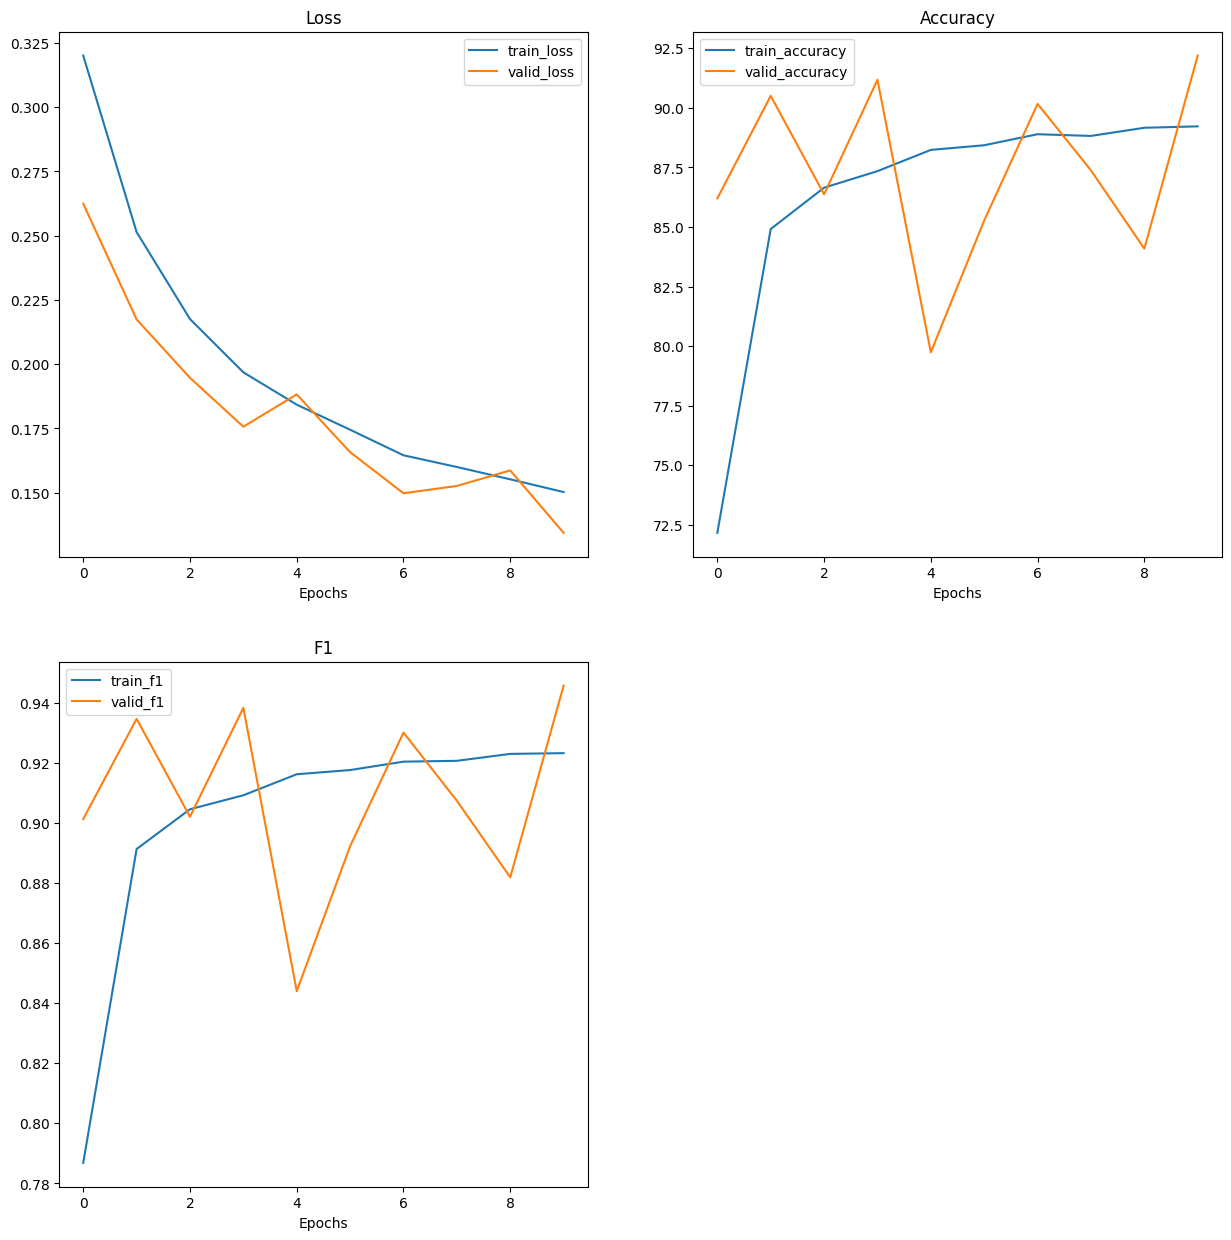

In [ ]:
# Linear class
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
plot_loss_curves(model_14_results)

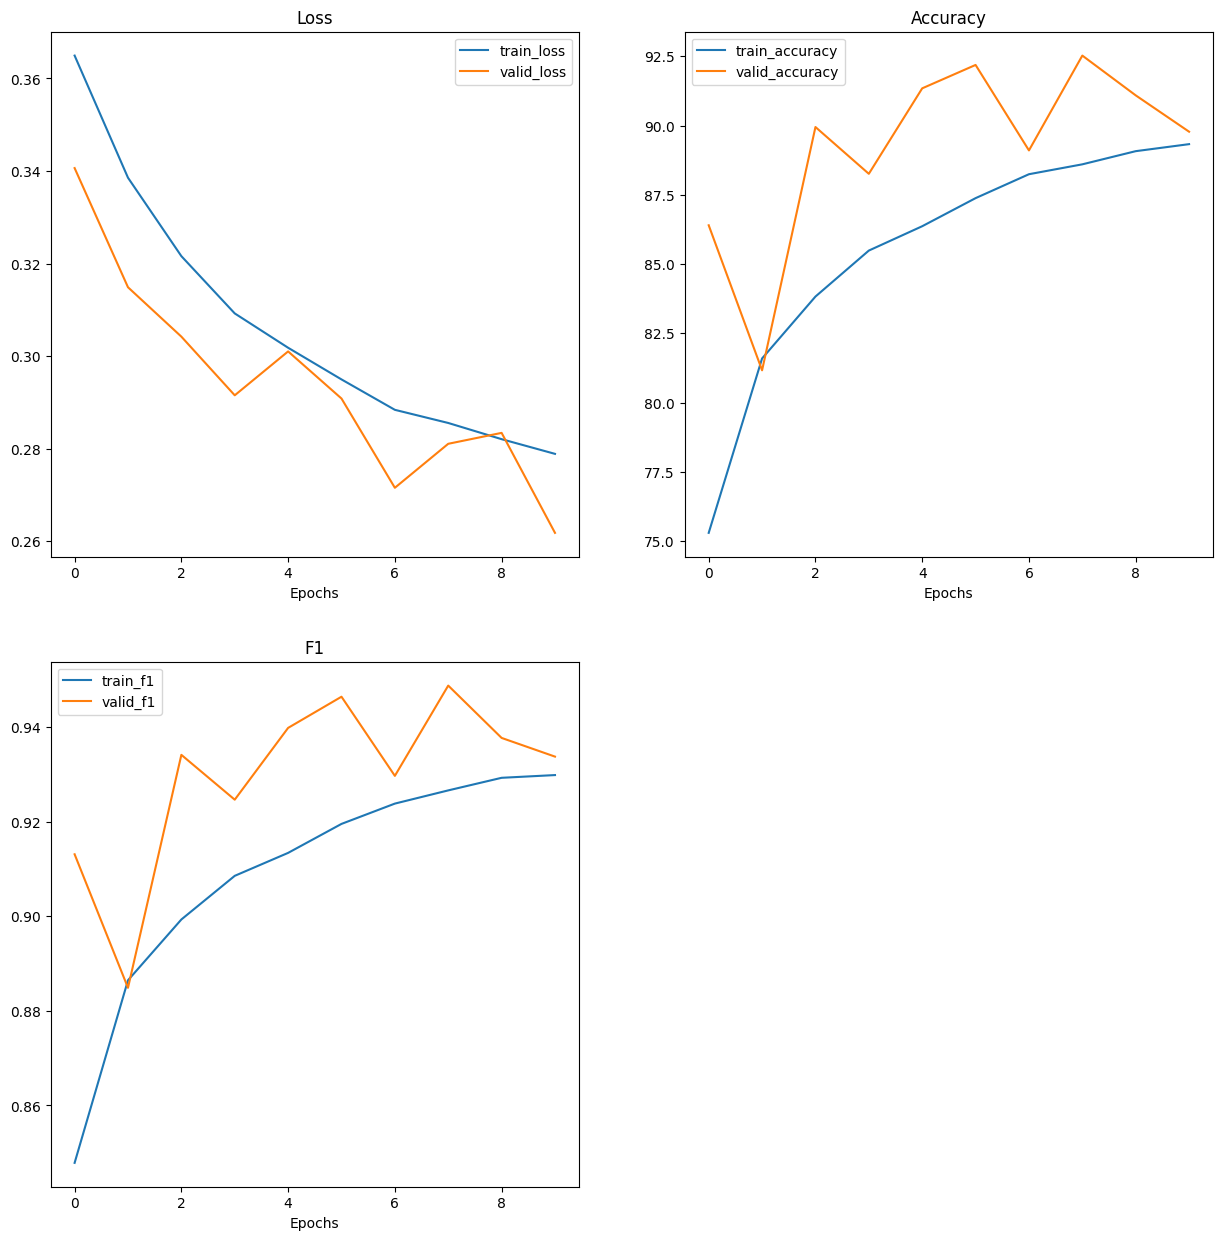

In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
plot_loss_curves(model_15_results)

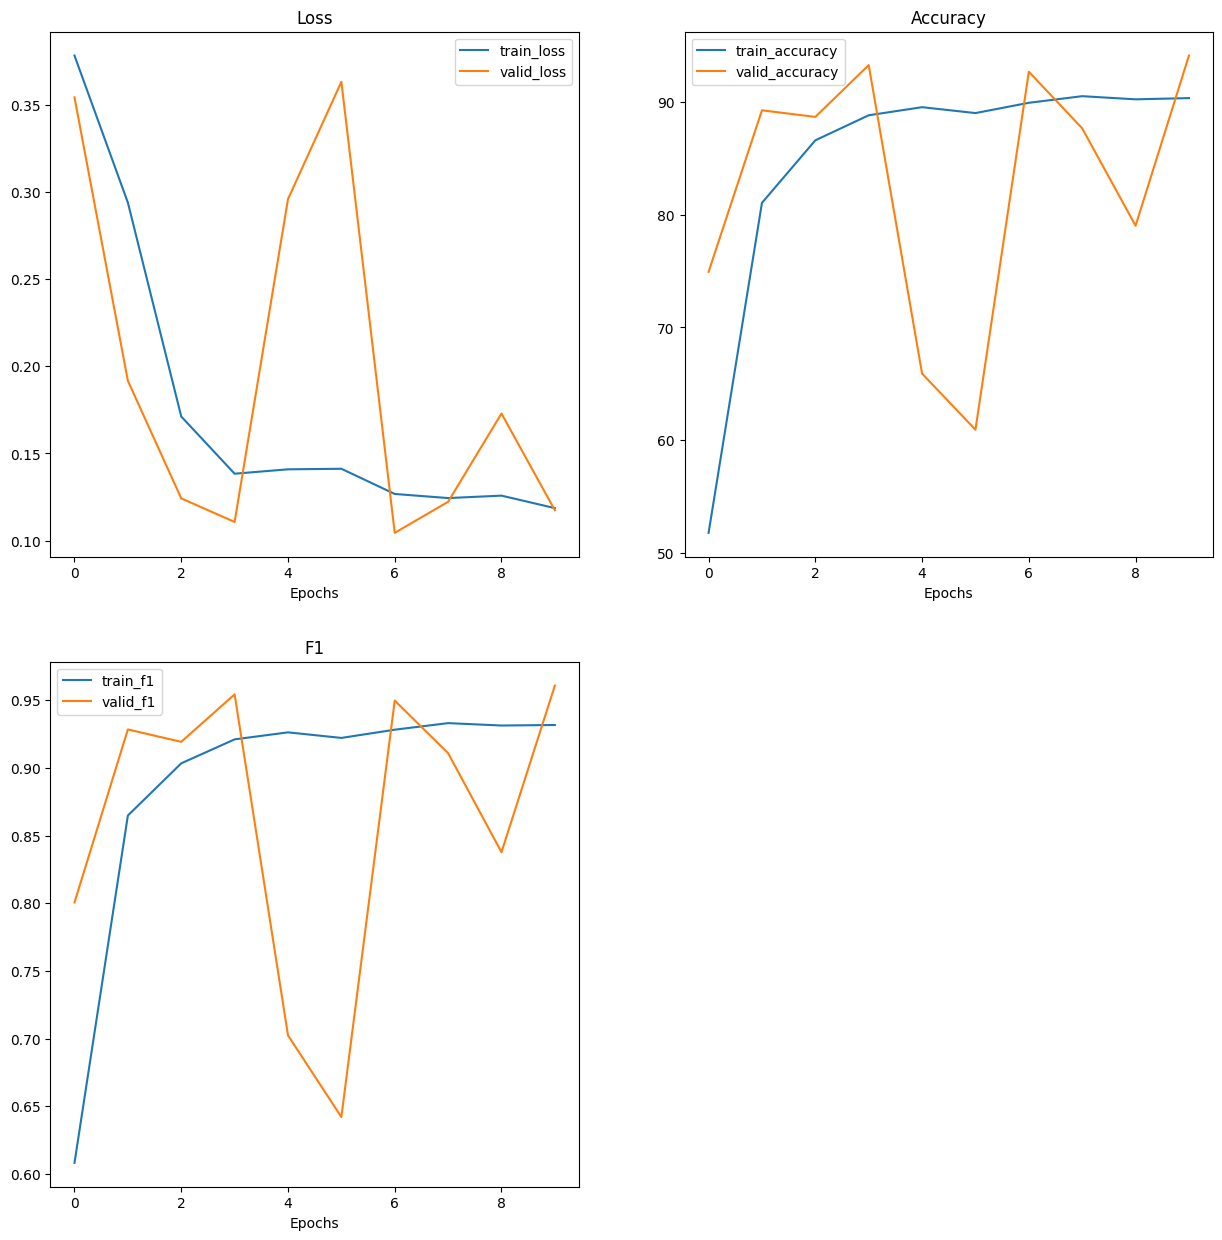

In [ ]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Weighed
plot_loss_curves(model_16_results)

***
### h. Changing **optimizer**
***

#### Setting up models

In [ ]:
# Linear
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 5
model_17 = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_17.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [ ]:
# Using Adam optimizer
optimizer_17 = torch.optim.Adam(params=model_17.parameters(), lr=0.0001)

In [ ]:
# Linear + ReLU
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
model_18 = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_18.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [ ]:
# Using Adam optimizer
optimizer_18 = torch.optim.Adam(params=model_18.parameters(), lr=0.0001)

In [ ]:
#CNN
torch.manual_seed(42)

# Number of linear layers: 1
# Number of hidden units: 5
model_19 = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_19.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)

In [ ]:
# Using Adam optimizer
optimizer_19 = torch.optim.Adam(params=model_19.parameters(), lr=0.01)

#### Training

In [ ]:
#Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Linear
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Number of linear layers: 2
# Number of hidden units: 5
# Using weighed loss function
# Train model
model_17_results = train(model=model_17,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_17,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.43332 | Train accuracy: 77.64% | Train F1: 0.83
Validation loss: 0.13461 | Validation accuracy: 93.29%
 | Validation F1: 0.96
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.13521 | Train accuracy: 89.98% | Train F1: 0.93
Validation loss: 0.09087 | Validation accuracy: 93.04%
 | Validation F1: 0.95
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.14822 | Train accuracy: 89.72% | Train F1: 0.93
Validation loss: 0.13952 | Validation accuracy: 93.63%
 | Validation F1: 0.96
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.19981 | Train accuracy: 88.28% | Train F1: 0.92
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Using weighed loss function
# Train model
model_18_results = train(model=model_18,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_18,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37485 | Train accuracy: 27.29% | Train F1: 0.01
Validation loss: 0.36859 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37463 | Train accuracy: 27.06% | Train F1: 0.00
Validation loss: 0.36859 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37494 | Train accuracy: 27.13% | Train F1: 0.00
Validation loss: 0.36859 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37463 | Train accuracy: 27.06% | Train F1: 0.00
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# CNN
# Number of linear layers: 1
# Number of hidden units: 5
#Using weighed loss function
# Train model
model_19_results = train(model=model_19,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_19,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.75518 | Train accuracy: 69.93% | Train F1: 0.82
Validation loss: 0.36835 | Validation accuracy: 74.32%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37465 | Train accuracy: 64.90% | Train F1: 0.77
Validation loss: 0.36915 | Validation accuracy: 25.68%
 | Validation F1: 0.00
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37509 | Train accuracy: 32.73% | Train F1: 0.21
Validation loss: 0.36843 | Validation accuracy: 74.32%
 | Validation F1: 0.85
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37475 | Train accuracy: 44.18% | Train F1: 0.50
Valida

#### Results

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 5
# Weighed
# Adam
model_17_results

{'train_loss': [0.4333240051782923,
  0.13520839918055572,
  0.14822469657519832,
  0.1998050399852218,
  0.12736818059056532,
  0.2019367761167814,
  0.1767215750987816,
  0.19240377652431562,
  0.10710237472994777,
  0.14186562464601593],
 'train_acc': [77.63671875,
  89.98084435096153,
  89.7235576923077,
  88.2831280048077,
  91.22596153846153,
  88.51412259615384,
  90.07662259615384,
  89.1864483173077,
  93.44576322115384,
  90.6005859375],
 'train_f1': [0.8339376359680928,
  0.9293667362560891,
  0.927380125086866,
  0.9166812227074236,
  0.9386979796235537,
  0.9180499737899702,
  0.9296508598228245,
  0.9235048678720444,
  0.954131592509878,
  0.933055120848548],
 'valid_loss': [0.13461350883684448,
  0.09086726271119472,
  0.1395229539311667,
  0.10802967729348992,
  0.3418483524205717,
  0.3199240731931216,
  0.10925548871022624,
  0.11519591740609424,
  0.21005903778446688,
  0.22918218011359018],
 'valid_acc': [93.28872141372142,
  93.03534303534303,
  93.62655925155926,


In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
# Adam
model_18_results

{'train_loss': [0.3748459815979004,
  0.37463156832382083,
  0.3749432028271258,
  0.3746315680909902,
  0.37463156832382083,
  0.3747873848769814,
  0.37463156785815954,
  0.37478738534264266,
  0.37478738534264266,
  0.3747873855754733],
 'train_acc': [27.291165865384617,
  27.06017127403846,
  27.13153545673077,
  27.06017127403846,
  27.06017127403846,
  27.095853365384617,
  27.06017127403846,
  27.095853365384617,
  27.095853365384617,
  27.095853365384617],
 'train_f1': [0.013311148086522463,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'valid_loss': [0.3685856936751185,
  0.3685856936751185,
  0.3685856936751185,
  0.3685856936751185,
  0.3685856936751185,
  0.3685856936751185,
  0.3685856936751185,
  0.3685856936751185,
  0.3685856936751185,
  0.3685856936751185],
 'valid_acc': [25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.675675675675677,
  25.67

In [ ]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Weighed
# Adam
model_19_results

{'train_loss': [0.7551835128106177,
  0.374645643401891,
  0.37508739880286157,
  0.374747869791463,
  0.37465741764754057,
  0.37501375563442707,
  0.37484911317005754,
  0.37493737251497805,
  0.37512708571739495,
  0.37497710110619664],
 'train_acc': [69.92563100961539,
  64.90196814903847,
  32.73174579326923,
  44.18006310096154,
  69.63829627403847,
  28.560697115384617,
  33.24256310096154,
  69.62515024038461,
  42.67202524038461,
  34.13461538461539],
 'train_f1': [0.8163571000599161,
  0.7741628312966197,
  0.20715522215810733,
  0.4953560371517028,
  0.81703141283311,
  0.07022023619533993,
  0.2335766423357664,
  0.8176026077937472,
  0.4746906636670416,
  0.2704607046070461],
 'valid_loss': [0.36835362782349457,
  0.3691496792677286,
  0.36843050009495504,
  0.3684243745095021,
  0.3693162613623851,
  0.3688750218700718,
  0.3683245194119376,
  0.3691253782929601,
  0.368638076492258,
  0.3685145482823655],
 'valid_acc': [74.32432432432432,
  25.675675675675677,
  74.32432

#### Graphs

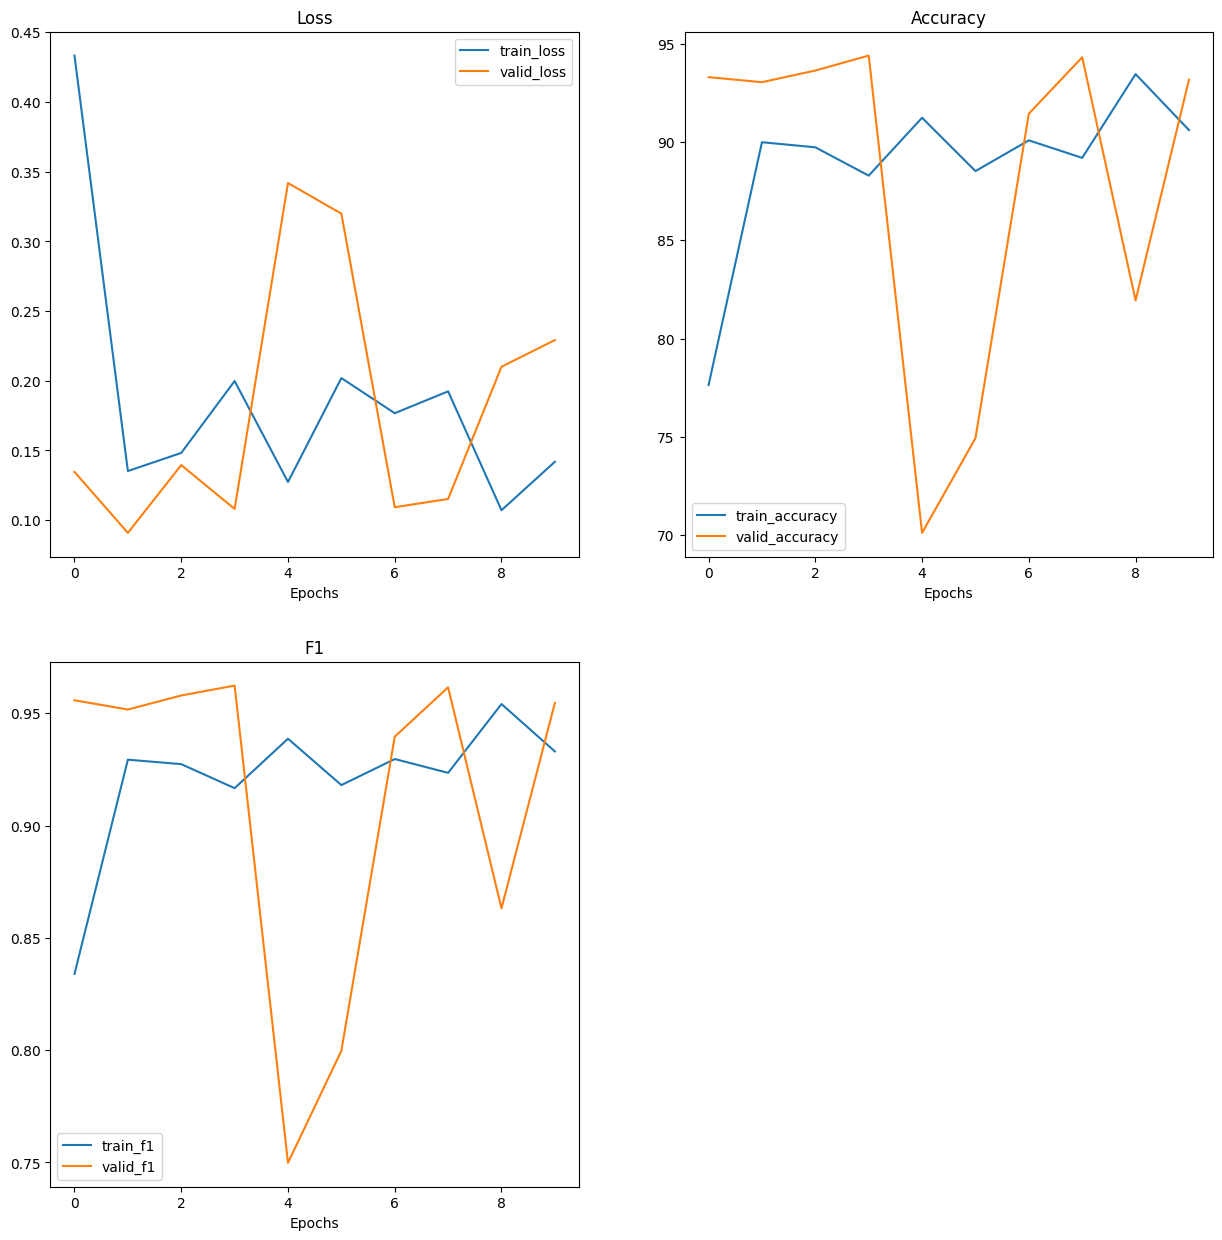

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 5
# Weighed
# Adam

plot_loss_curves(model_17_results)

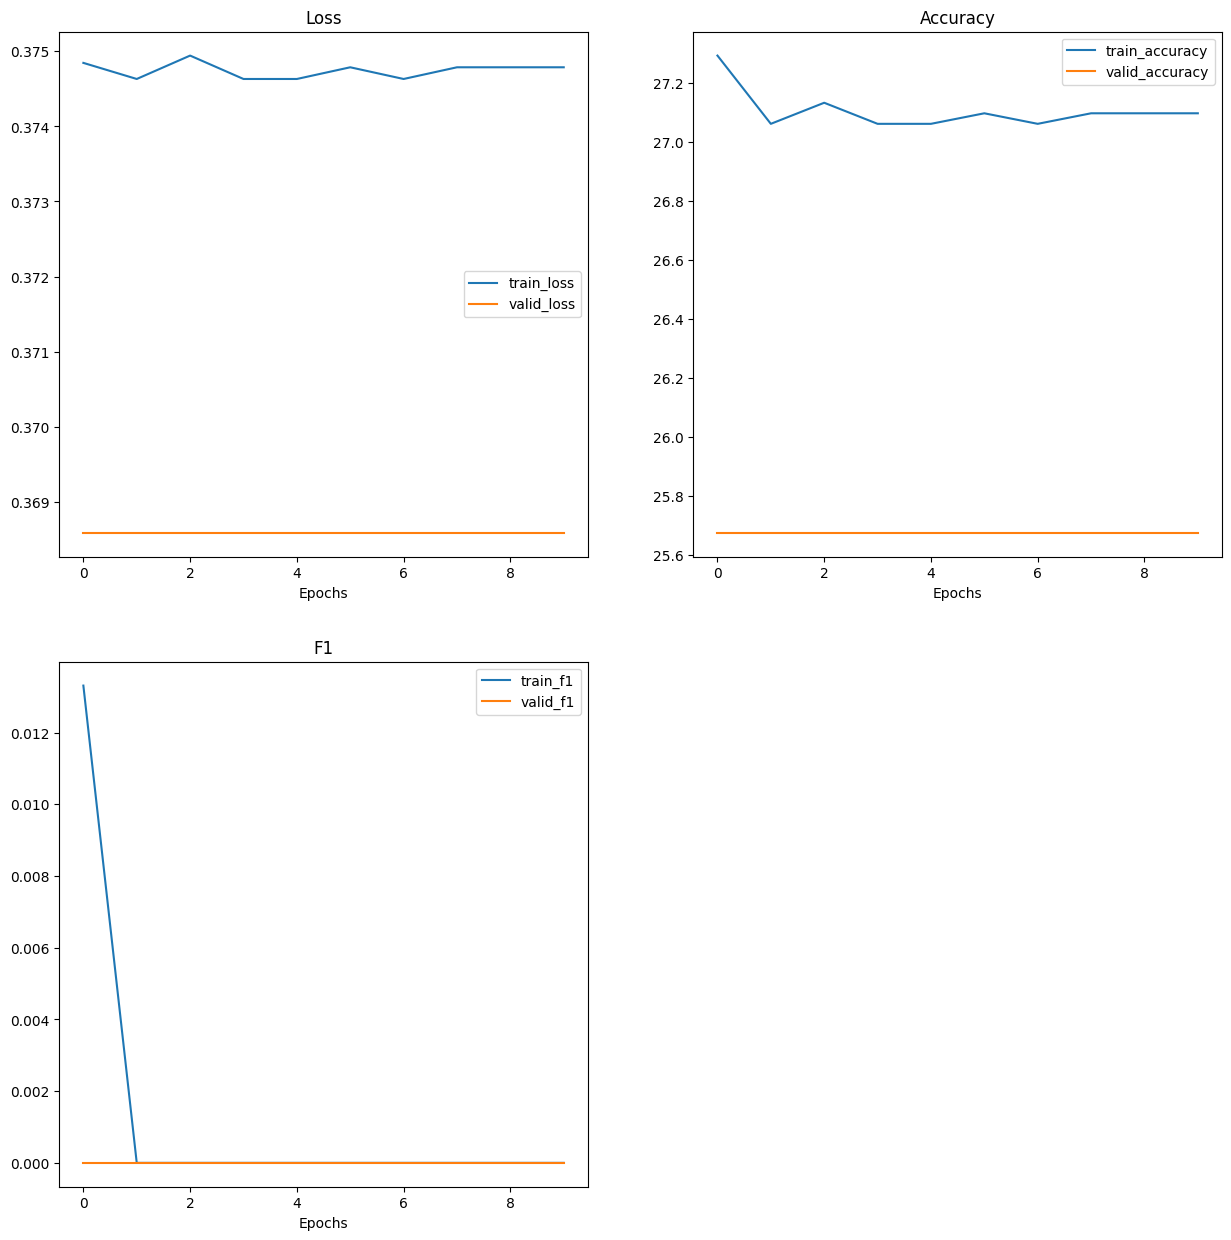

In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
# Adam
plot_loss_curves(model_18_results)

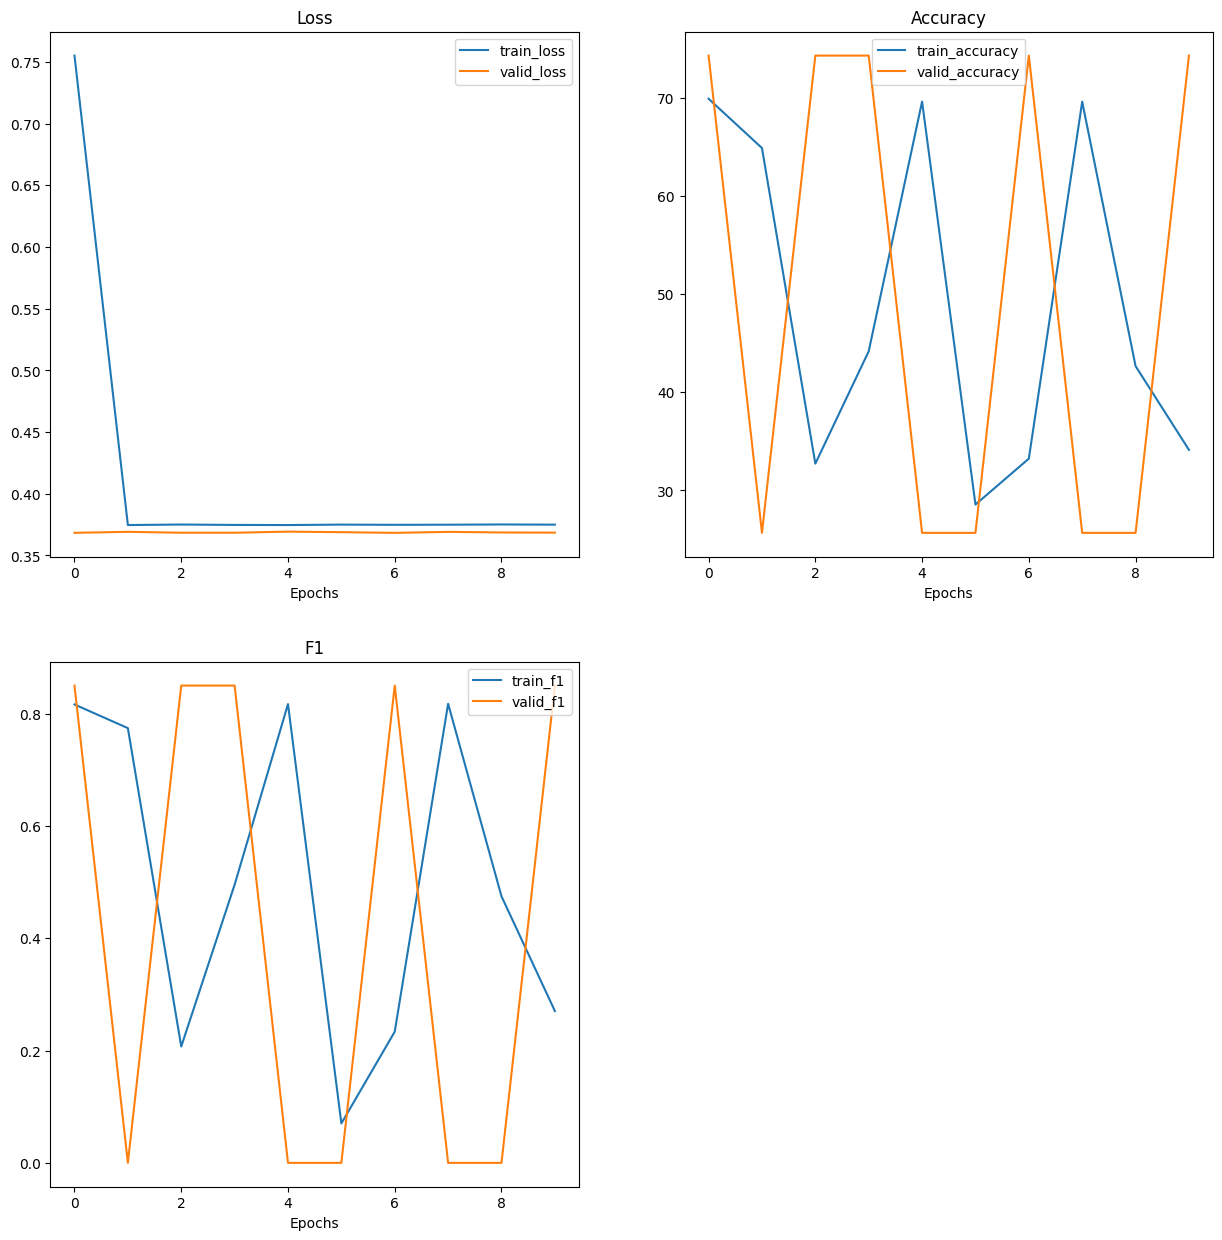

In [ ]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Weighed
# Adam

plot_loss_curves(model_19_results)

***
###  i. Increasing number of **epochs** - loss function not weighed
***

#### Setting up models

In [ ]:
#Linear
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
model_20 = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_20.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_20 = torch.optim.SGD(params=model_20.parameters(), lr=0.0001)

In [ ]:
# Linear + ReLU
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
model_21 = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_21.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [ ]:
optimizer_21 = torch.optim.SGD(params=model_21.parameters(), lr=0.0001)

In [ ]:
# CNN
torch.manual_seed(42)

# Number of linear layers: 1
# Number of hidden units: 5
model_22 = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_22.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_22 = torch.optim.SGD(params=model_22.parameters(), lr=0.01)

#### Training

In [ ]:
#Set number of epochs
NUM_EPOCHS = 50

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Train model
model_20_results = train(model=model_20,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_20,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.48387 | Train accuracy: 76.92% | Train F1: 0.86
Validation loss: 0.37860 | Validation accuracy: 88.34%
 | Validation F1: 0.93
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.36397 | Train accuracy: 85.70% | Train F1: 0.91
Validation loss: 0.30729 | Validation accuracy: 87.42%
 | Validation F1: 0.92
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.31216 | Train accuracy: 88.50% | Train F1: 0.93
Validation loss: 0.27429 | Validation accuracy: 91.68%
 | Validation F1: 0.94
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.28217 | Train accuracy: 89.60% | Train F1: 0.93
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Train model
model_21_results = train(model=model_21,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_21,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.52649 | Train accuracy: 73.39% | Train F1: 0.85
Validation loss: 0.44584 | Validation accuracy: 77.20%
 | Validation F1: 0.86
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.43642 | Train accuracy: 77.98% | Train F1: 0.87
Validation loss: 0.39152 | Validation accuracy: 78.46%
 | Validation F1: 0.87
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.39955 | Train accuracy: 81.51% | Train F1: 0.89
Validation loss: 0.36549 | Validation accuracy: 86.06%
 | Validation F1: 0.91
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37742 | Train accuracy: 83.40% | Train F1: 0.90
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Train model
model_22_results = train(model=model_22,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_22,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.58477 | Train accuracy: 72.17% | Train F1: 0.84
Validation loss: 0.49315 | Validation accuracy: 74.41%
 | Validation F1: 0.85
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.35183 | Train accuracy: 85.05% | Train F1: 0.90
Validation loss: 0.24291 | Validation accuracy: 89.19%
 | Validation F1: 0.93
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.26186 | Train accuracy: 89.76% | Train F1: 0.93
Validation loss: 0.19934 | Validation accuracy: 92.95%
 | Validation F1: 0.95
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.22067 | Train accuracy: 91.19% | Train F1: 0.94
Valida

#### Results

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
model_20_results

{'train_loss': [0.4838724809233099,
  0.3639689616393298,
  0.31215895514469594,
  0.28216813429025933,
  0.2641354928491637,
  0.25164957909146324,
  0.23696518526412547,
  0.2309048340539448,
  0.22522123623639345,
  0.21815733035327867,
  0.20962996874004602,
  0.20679516665404662,
  0.20441623002989218,
  0.20147904916666448,
  0.197286595008336,
  0.19466921608545817,
  0.19064892703318037,
  0.19071532896487042,
  0.18779365142108873,
  0.1853230896522291,
  0.1833249179762788,
  0.18328982131788507,
  0.18192909489152953,
  0.1808897989394609,
  0.17817052610917017,
  0.1773205928329844,
  0.17634516424732283,
  0.17366572842001915,
  0.17394291935488582,
  0.17300920447451063,
  0.17237352731171995,
  0.16983088350389153,
  0.17081859035533853,
  0.1676736800582148,
  0.16754066947032697,
  0.16939358078525402,
  0.1638629431836307,
  0.16778663324657828,
  0.16707221808610484,
  0.16529494745191187,
  0.1648632362484932,
  0.16428580103092827,
  0.16179366881260648,
  0.160852

In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
model_21_results

{'train_loss': [0.5264910561963916,
  0.4364248439669609,
  0.3995487157953903,
  0.37741961574647576,
  0.3638768255477771,
  0.35329308337531984,
  0.3421025611460209,
  0.3381916257785633,
  0.33292692387476563,
  0.3285857253940776,
  0.32105574756860733,
  0.31992397317662835,
  0.3173792327288538,
  0.31476728606503457,
  0.31294786813668907,
  0.3100253379670903,
  0.30744799959938973,
  0.30743729206733406,
  0.3054647644748911,
  0.3034415824804455,
  0.3014493325026706,
  0.30142244591843337,
  0.3003773046657443,
  0.2992907533189282,
  0.29855443770065904,
  0.2980905483709648,
  0.29633930569980294,
  0.2950069432845339,
  0.2949921014951542,
  0.2934224674827419,
  0.2941352683119476,
  0.2921902408124879,
  0.29224714217707515,
  0.29063701024279,
  0.2904827643651515,
  0.29116316279396415,
  0.2894210285739973,
  0.2902217818191275,
  0.2895089874509722,
  0.2876337399939075,
  0.28853307315148413,
  0.28694429446477443,
  0.28570965107064694,
  0.2849927918286994,
  0

In [ ]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 5
model_22_results

{'train_loss': [0.5847742322366685,
  0.3518283849116415,
  0.2618621651781723,
  0.22066940055810846,
  0.21976771805202588,
  0.2206976576417219,
  0.19824114526272751,
  0.19300301889597904,
  0.19356157135916874,
  0.17909192171646282,
  0.16846515535144135,
  0.1604764748190064,
  0.17789548344444484,
  0.15388060493569355,
  0.14516010257648304,
  0.14600837178295478,
  0.13770571946224663,
  0.135450771485921,
  0.12578207810292952,
  0.12250974836933892,
  0.12229631478112424,
  0.12235589746705955,
  0.12582142316387035,
  0.4666346764424816,
  0.2204929139406886,
  0.14915748445491772,
  0.14074200912727974,
  0.1382801058352925,
  0.13283853718166938,
  0.12927483816747554,
  0.11842087918921607,
  0.11537520339334151,
  0.1119309220375726,
  0.11360848998447182,
  0.1336038142653706,
  0.11182495363027556,
  0.10524287032603752,
  0.10323065457487246,
  0.10311728851957014,
  0.09944990341318771,
  0.10473437535983976,
  0.08650032223340531,
  0.08931481506078853,
  0.08752

#### Graphs

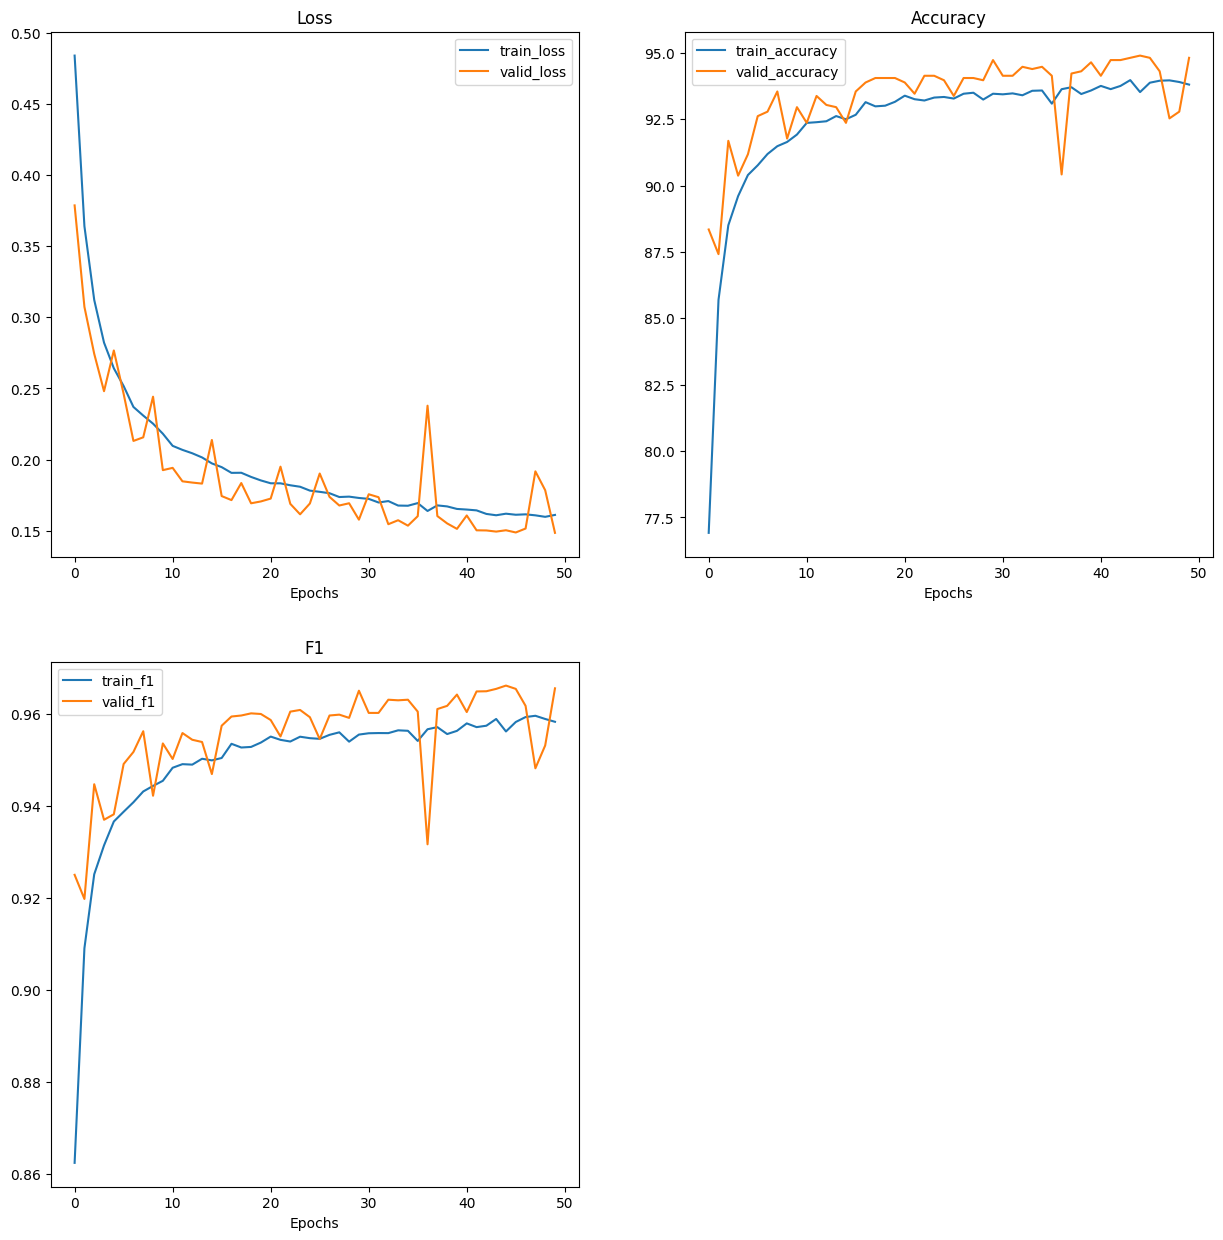

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
plot_loss_curves(model_20_results)

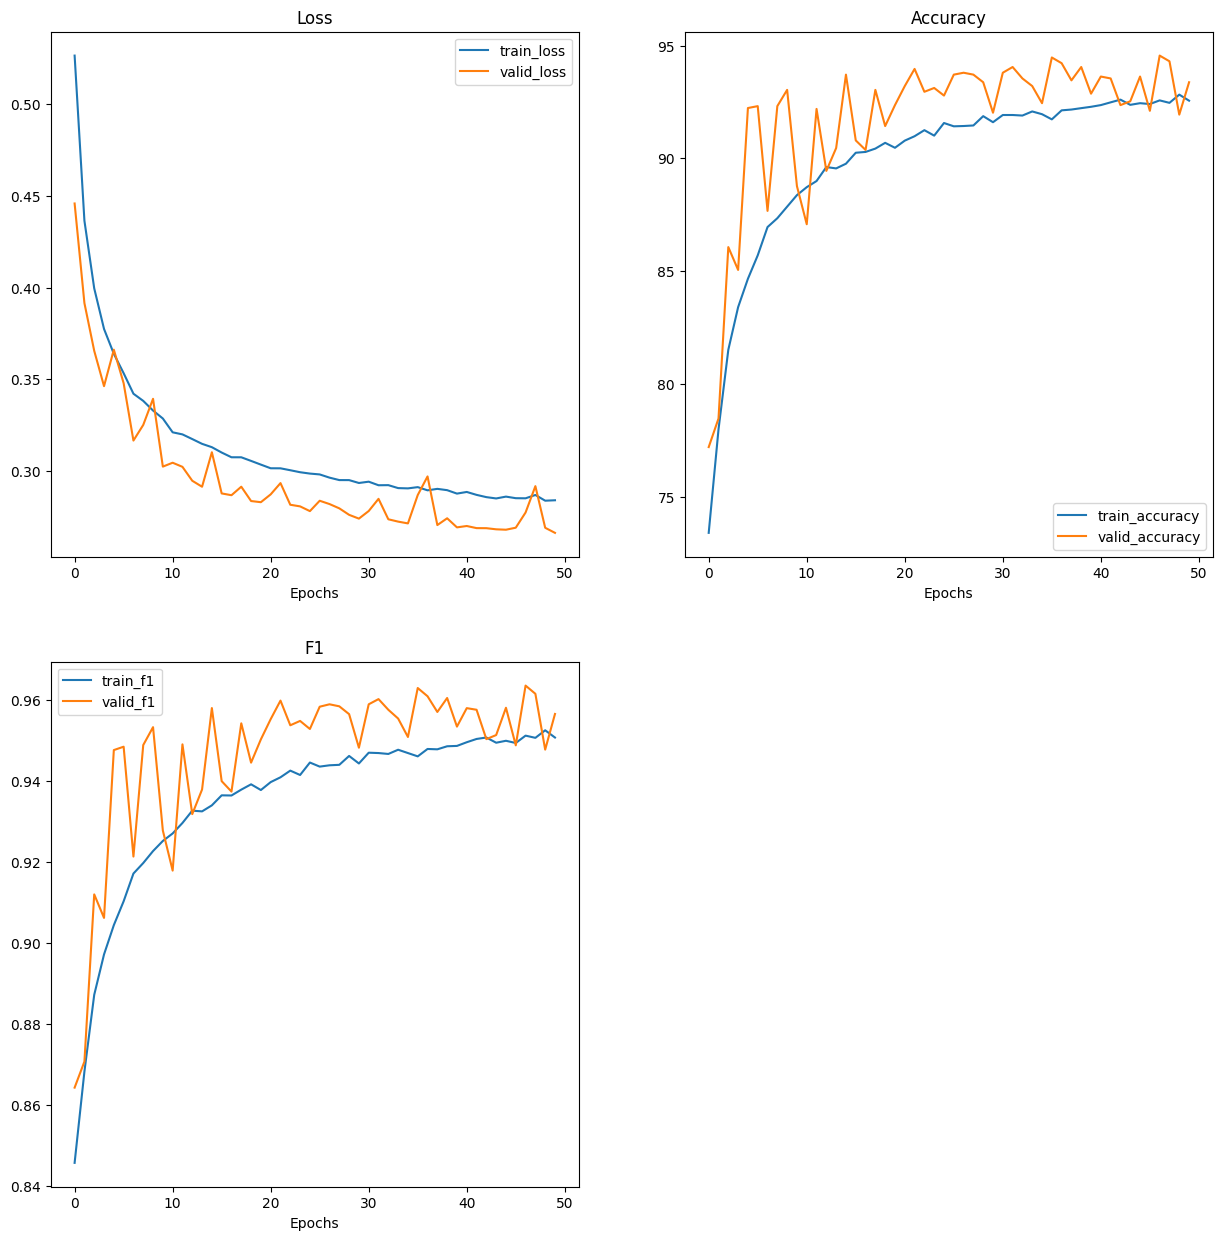

In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
plot_loss_curves(model_21_results)

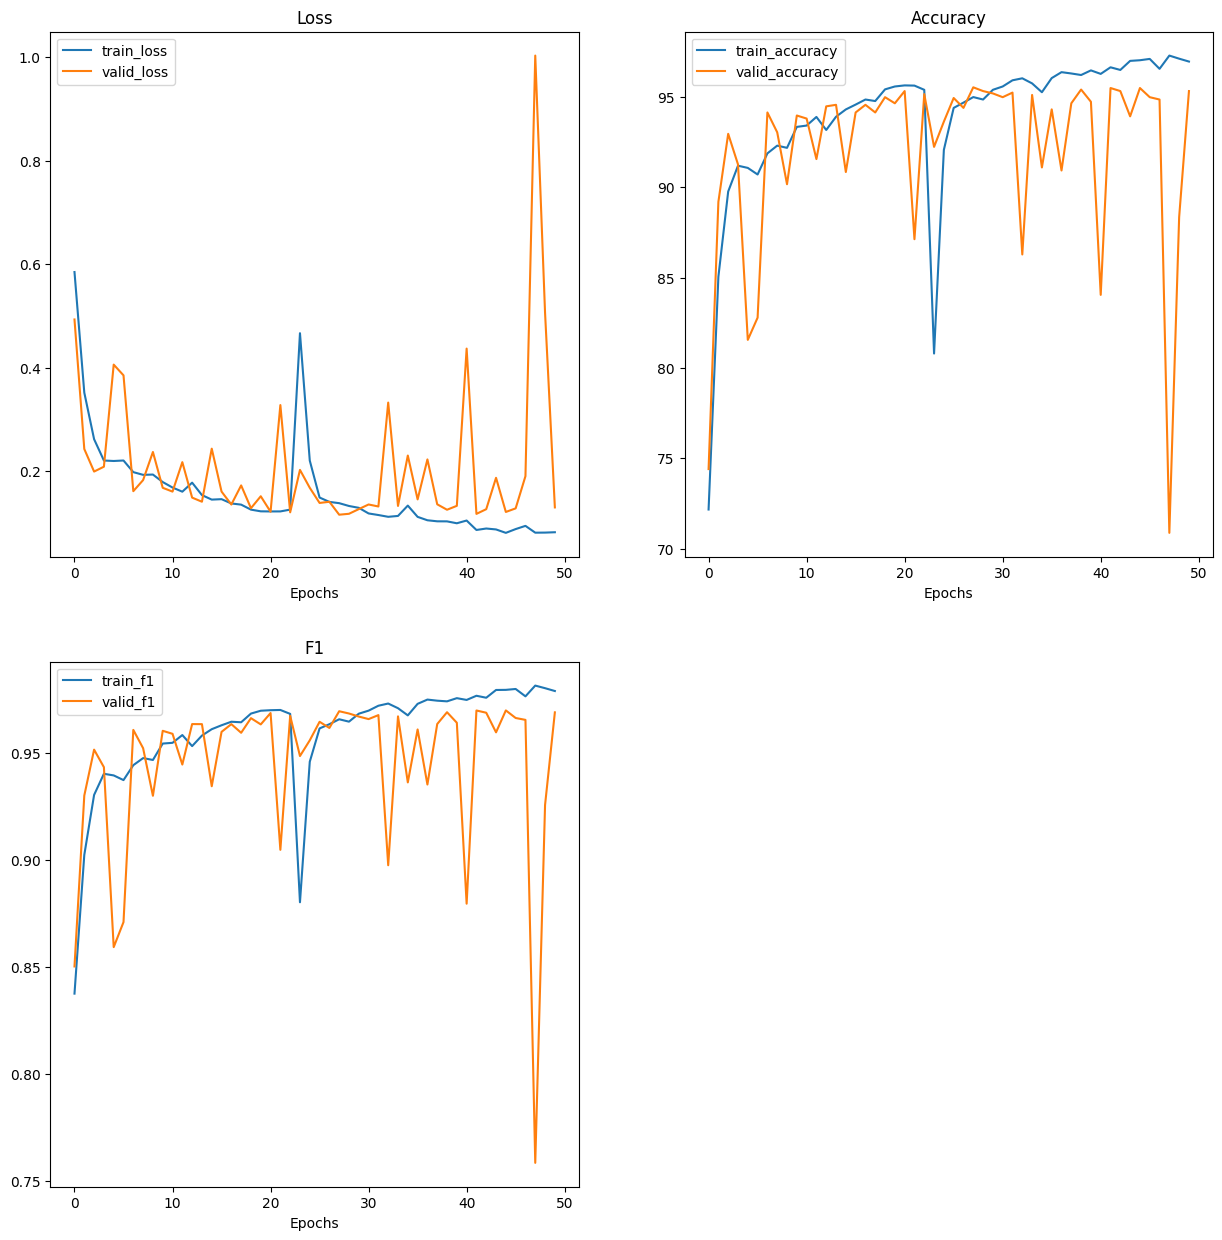

In [ ]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 5
plot_loss_curves(model_22_results)

### j. Increasing the number of epochs - **weighed**

#### Setting up models

In [ ]:
#Linear
torch.manual_seed(42)
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_23 = XRAYS_linear2(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_23.to(device)

XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_23 = torch.optim.SGD(params=model_23.parameters(), lr=0.0001)

In [ ]:
#Linear + ReLU
torch.manual_seed(42)

# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_24 = XRAYS_linear2ReLU(input_shape=409600, # one for every pixel
    hidden_units=10, # how many units in the hidden layer
    output_shape=1
)
model_24.to(device)

XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [ ]:
optimizer_24 = torch.optim.SGD(params=model_24.parameters(), lr=0.0001)

In [ ]:
#CNN
torch.manual_seed(42)

# Number of linear layers: 1
# Number of hidden units: 5
model_25 = XRAYS_CNN(input_shape=1, # 1 colour channel
    hidden_units=5, # how many units in the hidden layer
    output_shape=1
)
model_25.to(device)

XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_25 = torch.optim.SGD(params=model_25.parameters(), lr=0.01)

#### Training

In [ ]:
#Set number of epochs
NUM_EPOCHS = 50

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Using weighed loss function

# Train model
model_23_results = train(model=model_23,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_23,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.32010 | Train accuracy: 72.17% | Train F1: 0.79
Validation loss: 0.26245 | Validation accuracy: 86.20%
 | Validation F1: 0.90
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.25142 | Train accuracy: 84.91% | Train F1: 0.89
Validation loss: 0.21744 | Validation accuracy: 90.50%
 | Validation F1: 0.93
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.21756 | Train accuracy: 86.65% | Train F1: 0.90
Validation loss: 0.19468 | Validation accuracy: 86.37%
 | Validation F1: 0.90
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.19684 | Train accuracy: 87.34% | Train F1: 0.91
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Using weighed loss function
# Train model
model_24_results = train(model=model_24,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_24,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.36493 | Train accuracy: 75.30% | Train F1: 0.85
Validation loss: 0.34063 | Validation accuracy: 86.40%
 | Validation F1: 0.91
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.33854 | Train accuracy: 81.59% | Train F1: 0.89
Validation loss: 0.31488 | Validation accuracy: 81.17%
 | Validation F1: 0.88
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.32160 | Train accuracy: 83.83% | Train F1: 0.90
Validation loss: 0.30421 | Validation accuracy: 89.95%
 | Validation F1: 0.93
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.30923 | Train accuracy: 85.49% | Train F1: 0.91
Valida

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Using weighed loss function
# Train model
model_25_results = train(model=model_25,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer_25,
                        loss_fn=loss_fn_weighed,
                        epochs=NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.37826 | Train accuracy: 51.76% | Train F1: 0.61
Validation loss: 0.35432 | Validation accuracy: 74.94%
 | Validation F1: 0.80
Epoch: 1
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.29391 | Train accuracy: 81.03% | Train F1: 0.86
Validation loss: 0.19169 | Validation accuracy: 89.27%
 | Validation F1: 0.93
Epoch: 2
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.17120 | Train accuracy: 86.61% | Train F1: 0.90
Validation loss: 0.12421 | Validation accuracy: 88.69%
 | Validation F1: 0.92
Epoch: 3
---------
Looked at 0/4077 samples
Looked at 1024/4077 samples
Looked at 2048/4077 samples
Looked at 3072/4077 samples
Train loss: 0.13838 | Train accuracy: 88.83% | Train F1: 0.92
Valida

#### Results

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_23_results

{'train_loss': [0.320098091266118,
  0.25141966703813523,
  0.21756167279090732,
  0.19683810364222154,
  0.18425630178535357,
  0.17449697450501844,
  0.16454684047494084,
  0.1599989258684218,
  0.15519810345722362,
  0.1502494122250937,
  0.14449085912201554,
  0.14223521100939251,
  0.13989395555108786,
  0.13750270690070465,
  0.1347159379220102,
  0.1326390429167077,
  0.13002199691254646,
  0.12941076658898965,
  0.12731328324298374,
  0.1255002832331229,
  0.12403127597644925,
  0.12366725175525062,
  0.12220596315455623,
  0.12144849929609336,
  0.11997983796754852,
  0.11869740934344009,
  0.11822793577448465,
  0.116802629083395,
  0.11645438498817384,
  0.11568578408332542,
  0.11521402295329608,
  0.11397780501283705,
  0.11389221408171579,
  0.11231640426558442,
  0.11211969287251122,
  0.11264970185584389,
  0.10988532731425948,
  0.11133713202434592,
  0.11097129122936167,
  0.10949823301052675,
  0.10958312836010009,
  0.10918832436436787,
  0.1077068064478226,
  0.106

In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
model_24_results

{'train_loss': [0.364930737297982,
  0.33854264742694795,
  0.3216021410189569,
  0.30922870140057057,
  0.30181035201530904,
  0.29496960109099746,
  0.2884006679523736,
  0.285560148418881,
  0.2820601526182145,
  0.2788872190285474,
  0.274596389150247,
  0.27381493512075394,
  0.2714719105279073,
  0.26967762887943536,
  0.26921955874422565,
  0.26665407815016806,
  0.26498946314677596,
  0.2645259405253455,
  0.2632308767642826,
  0.2619653589790687,
  0.26048417919082567,
  0.2605348447104916,
  0.25972494937013835,
  0.25906207447405905,
  0.25852114747976884,
  0.2579653350985609,
  0.25722202740143985,
  0.2557066553272307,
  0.2557657320285216,
  0.25430708547355607,
  0.2553408202365972,
  0.25373253715224564,
  0.25348727422533557,
  0.2530405984725803,
  0.2524953446118161,
  0.25249640829861164,
  0.2525509227416478,
  0.2519302251166664,
  0.25128053268417716,
  0.2502488478203304,
  0.2510899305343628,
  0.2495673496159725,
  0.24916181224398315,
  0.24831300327787176,


In [ ]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Weighed
model_25_results

{'train_loss': [0.37826233683153987,
  0.2939121949020773,
  0.1711970274336636,
  0.13837873830925673,
  0.14088656642707065,
  0.14121416295529343,
  0.12675209561712109,
  0.12440472297021188,
  0.1257963016832946,
  0.11863016635470558,
  0.11288515324122272,
  0.1097766051243525,
  0.11718795230262913,
  0.10860293156292755,
  0.10363151645287871,
  0.10957477825286333,
  0.10141579476476181,
  0.10304818793520099,
  0.09779999962483998,
  0.09465250973880757,
  0.09431048863916658,
  0.09489638677041512,
  0.09670495985483285,
  0.09175304427481024,
  0.08913531844154932,
  0.0872599140930106,
  0.0842072578452644,
  0.08194530007313006,
  0.08117064228281379,
  0.08017761411610991,
  0.07634254972072085,
  0.07428994797373889,
  0.07177801400393946,
  0.07286284340079874,
  0.07272939948597923,
  0.06952858869772172,
  0.06662864339887165,
  0.0696329804159177,
  0.06871856353245676,
  0.062281607279146556,
  0.06613893529720372,
  0.059092059291288024,
  0.05629796862558578,
  

#### Graphs

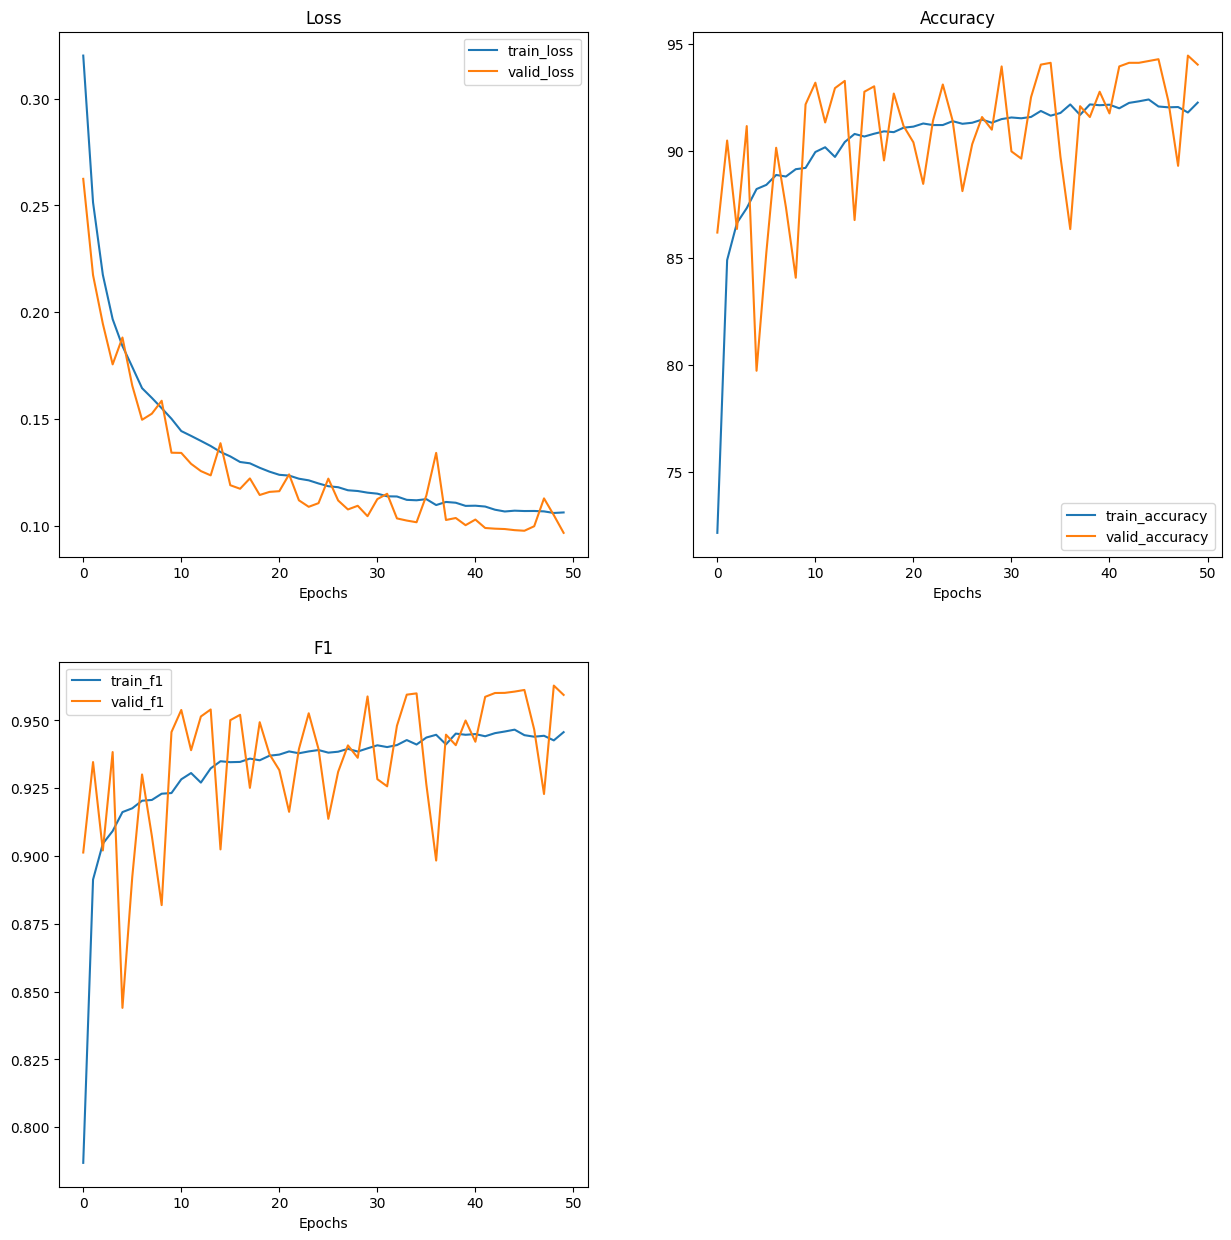

In [ ]:
# Linear
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
plot_loss_curves(model_23_results)

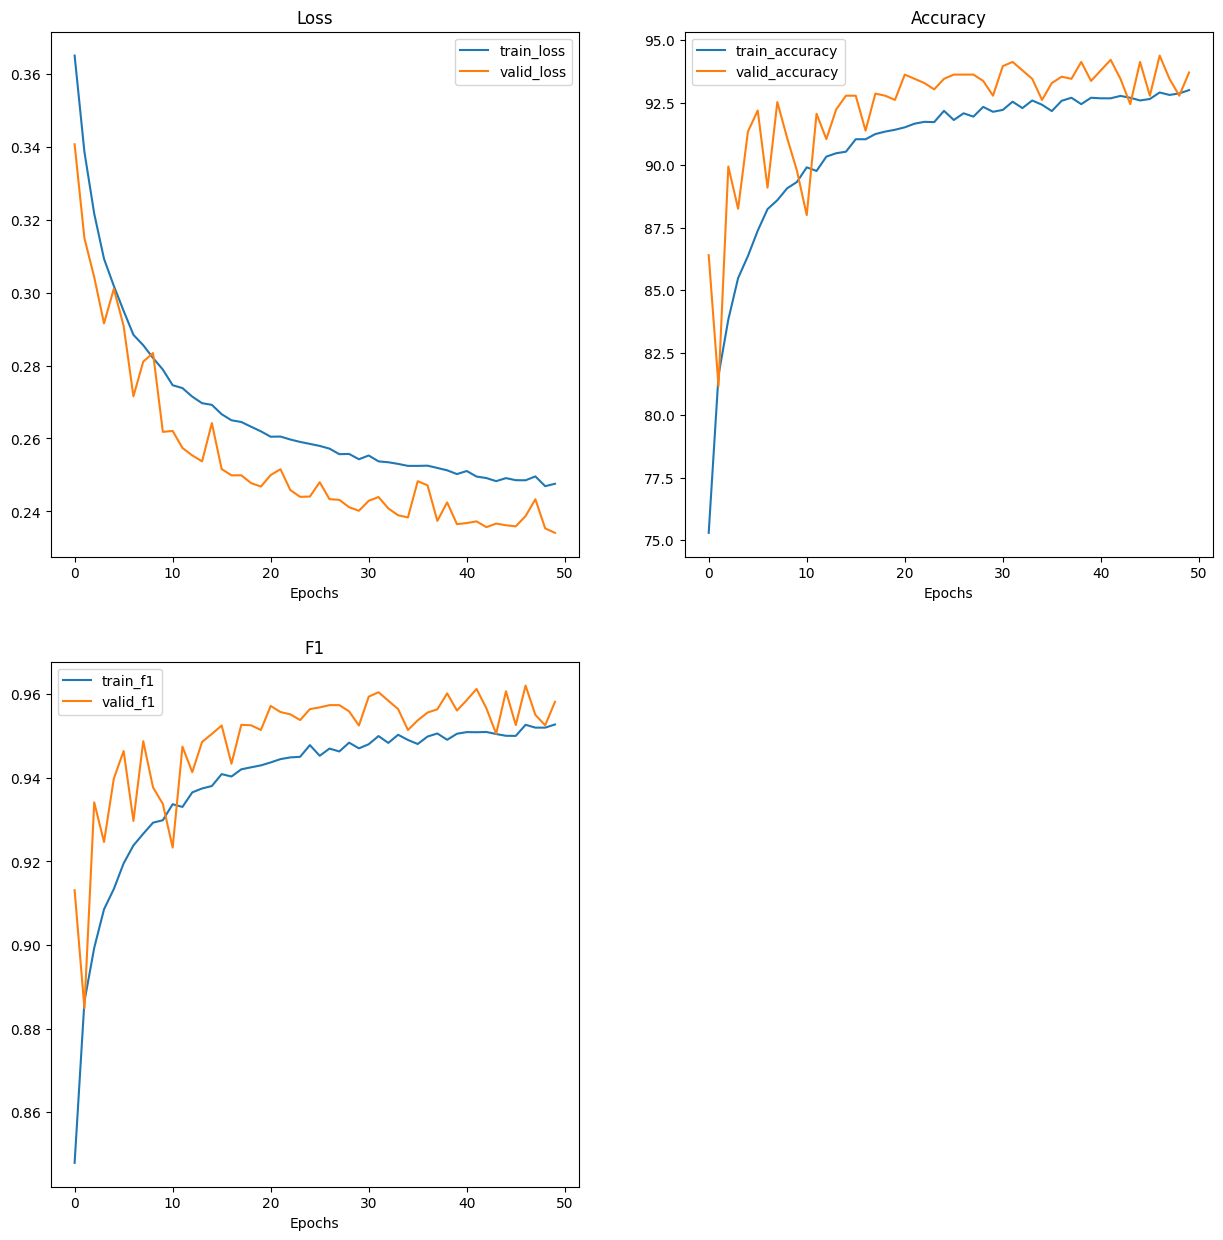

In [ ]:
# Linear + ReLU
# Number of linear layers: 2
# Number of hidden units: 10
# Weighed
plot_loss_curves(model_24_results)

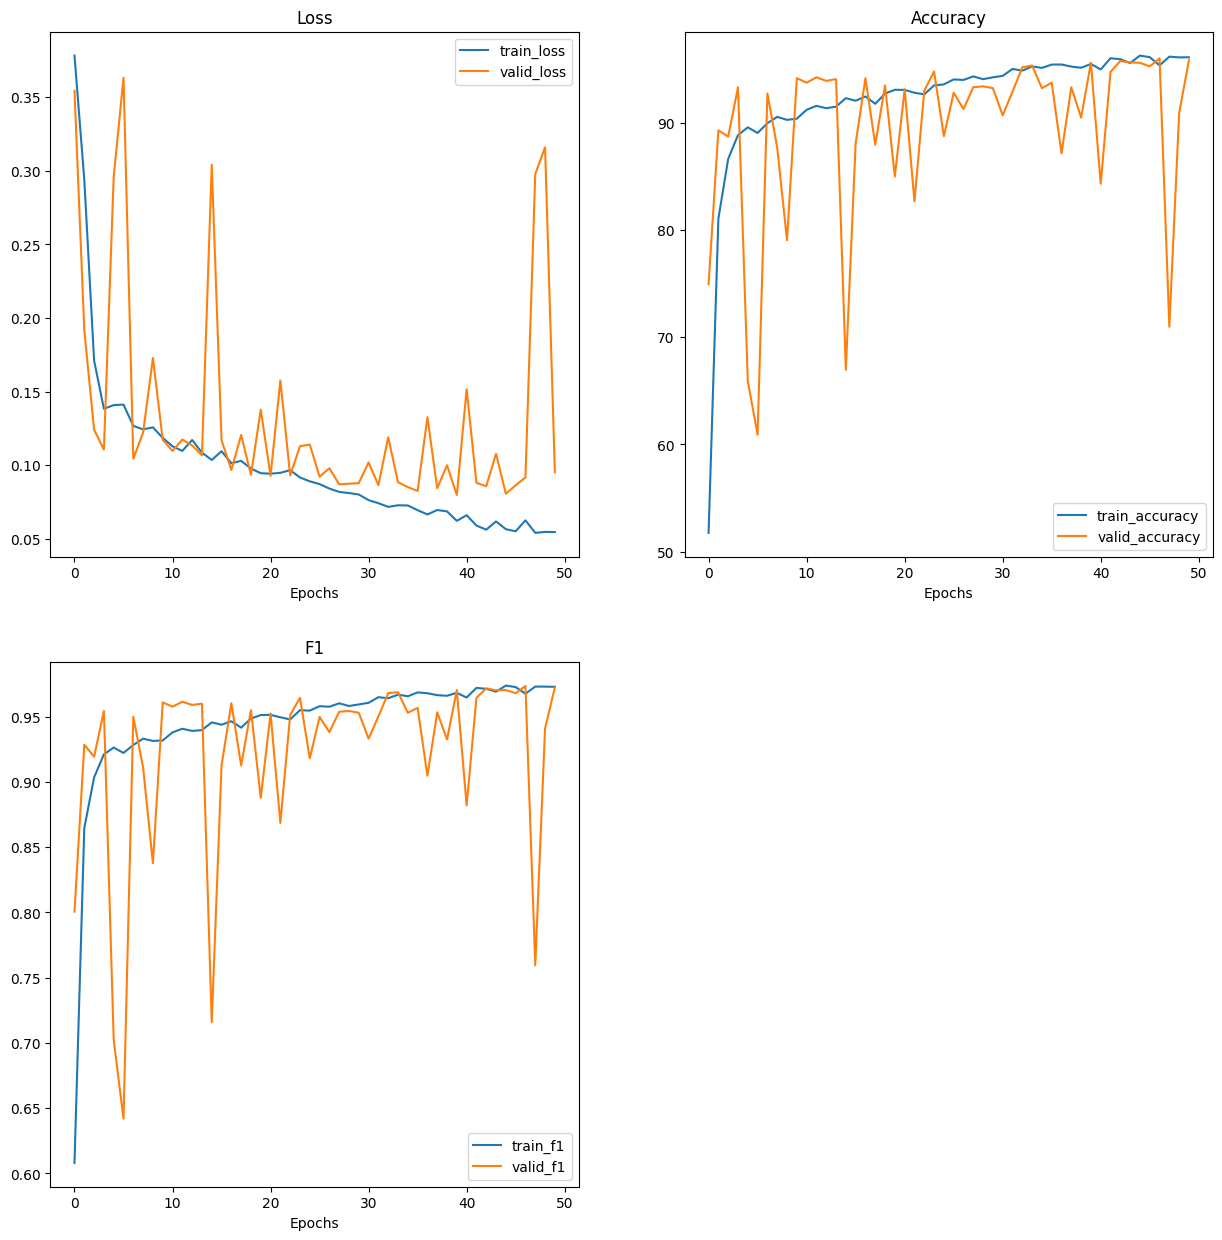

In [ ]:
# CNN
# Number of linear layers: 1
# Number of hidden units: 5
# Weighed
plot_loss_curves(model_25_results)

***
## 7. Saving models
***

In [ ]:
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
# 2. Create model save path
MODEL_NAME = "model_20.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_20.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_20.pth


In [ ]:
# 2. Create model save path
MODEL_NAME = "model_21.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_21.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_21.pth


In [ ]:
# 2. Create model save path
MODEL_NAME = "model_22.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_22.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_22.pth


In [ ]:
# 2. Create model save path
MODEL_NAME = "model_23.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_23.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_23.pth


In [ ]:
# 2. Create model save path
MODEL_NAME = "model_24.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_24.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_24.pth


In [ ]:
# 2. Create model save path
MODEL_NAME = "model_25.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_25.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_25.pth


## 8. Evaluation

### Linear models

#### Model 20

In [30]:
loaded_model_20 = XRAYS_linear2(input_shape=409600,
    hidden_units=10,
    output_shape=1)

loaded_model_20.to(device)

# Load model state dict
loaded_model_20.load_state_dict(torch.load('models/model_20.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_20.to(device)

print(f"Loaded model:\n{loaded_model_20}")
print(f"Model on device:\n{next(loaded_model_20.parameters()).device}")


Loaded model:
XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [31]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Testing
test_results_model_20, y_test, y_test_pred_model_20 = test(data_loader=test_dataloader,
                                                            model=loaded_model_20,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [32]:
test_results_model_20

{'test_acc': 93.42105263157895, 'test_f1': 0.9523809523809522}

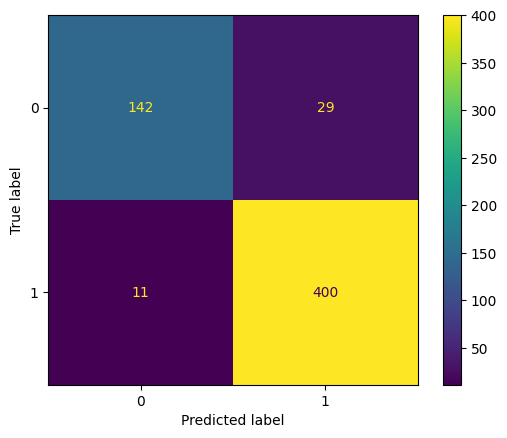

In [33]:
cm = confusion_matrix(y_test, y_test_pred_model_20)
ConfusionMatrixDisplay(cm).plot()

#### Model 23 (weighed loss function)

In [34]:
loaded_model_23 = XRAYS_linear2(input_shape=409600,
    hidden_units=10,
    output_shape=1)

loaded_model_23.to(device)

# Load model state dict
loaded_model_23.load_state_dict(torch.load('models/model_23.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_23.to(device)

print(f"Loaded model:\n{loaded_model_23}")
print(f"Model on device:\n{next(loaded_model_23.parameters()).device}")


Loaded model:
XRAYS_linear2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [35]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Testing
test_results_model_23, y_test, y_test_pred_model_23 = test(data_loader=test_dataloader,
                                                            model=loaded_model_23,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [36]:
test_results_model_23

{'test_acc': 91.06359649122807, 'test_f1': 0.9379652605459057}

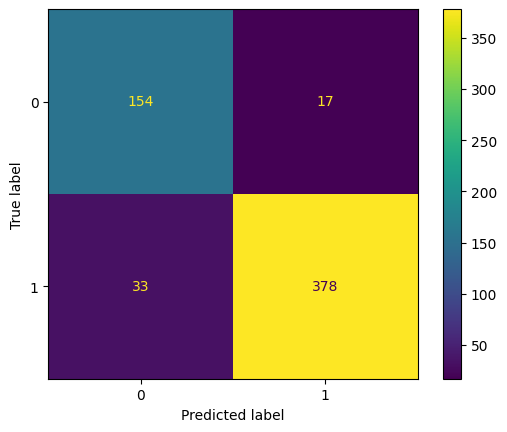

In [37]:
cm = confusion_matrix(y_test, y_test_pred_model_23)
ConfusionMatrixDisplay(cm).plot()

### Linear + ReLU models

#### Model 21

In [38]:
loaded_model_21 = XRAYS_linear2ReLU(input_shape=409600,
    hidden_units=10,
    output_shape=1)

# Load model state dict
loaded_model_21.load_state_dict(torch.load('models/model_21.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_21.to(device)

print(f"Loaded model:\n{loaded_model_21}")
print(f"Model on device:\n{next(loaded_model_21.parameters()).device}")

Loaded model:
XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)
Model on device:
cpu


In [39]:
test_results_model_21, y_test, y_test_pred_model_21 = test(data_loader=test_dataloader,
                                                            model=loaded_model_21,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [40]:
test_results_model_21

{'test_acc': 93.42105263157895, 'test_f1': 0.9528301886792453}

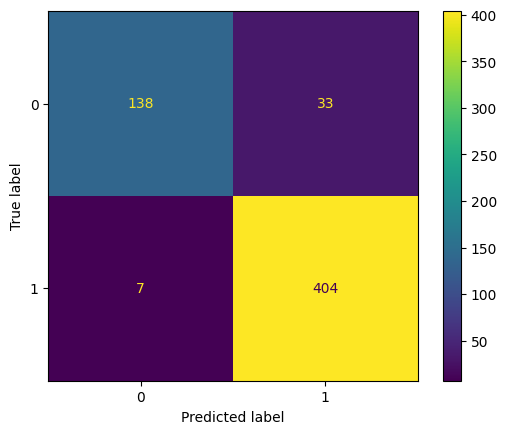

In [41]:
cm = confusion_matrix(y_test, y_test_pred_model_21)
ConfusionMatrixDisplay(cm).plot()

#### Model 24 (weighed loss function)

In [42]:
loaded_model_24 = XRAYS_linear2ReLU(input_shape=409600,
    hidden_units=10,
    output_shape=1)

# Load model state dict
loaded_model_24.load_state_dict(torch.load('models/model_24.pth', map_location=torch.device(device)))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_24.to(device)

print(f"Loaded model:\n{loaded_model_24}")
print(f"Model on device:\n{next(loaded_model_24.parameters()).device}")

Loaded model:
XRAYS_linear2ReLU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=409600, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)
Model on device:
cpu


In [43]:
test_results_model_24, y_test, y_test_pred_model_24 = test(data_loader=test_dataloader,
                                                            model=loaded_model_24,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [44]:
test_results_model_24

{'test_acc': 93.09210526315789, 'test_f1': 0.9498806682577566}

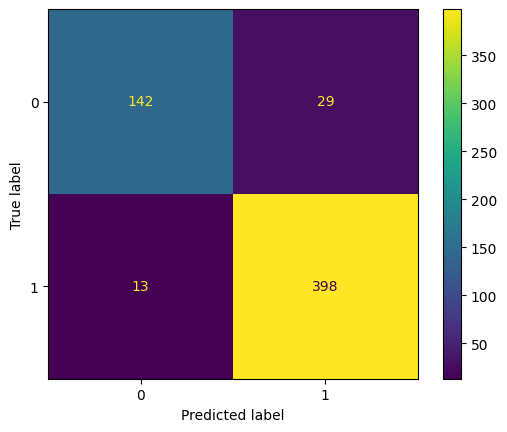

In [45]:
cm = confusion_matrix(y_test, y_test_pred_model_24)
ConfusionMatrixDisplay(cm).plot()

### CNN models

#### Model 22

In [46]:
loaded_model_22 = XRAYS_CNN(input_shape=1,
    hidden_units=5,
    output_shape=1
)

loaded_model_22.to(device)
# Load model state dict
loaded_model_22.load_state_dict(torch.load('models/model_22.pth', map_location=torch.device(device) ))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_22.to(device)

print(f"Loaded model:\n{loaded_model_22}")
print(f"Model on device:\n{next(loaded_model_22.parameters()).device}")

Loaded model:
XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [47]:
test_results_model_22, y_test, y_test_pred_model_22 = test(data_loader=test_dataloader,
                                                            model=loaded_model_22,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [48]:
test_results_model_22

{'test_acc': 93.09210526315789, 'test_f1': 0.9497607655502392}

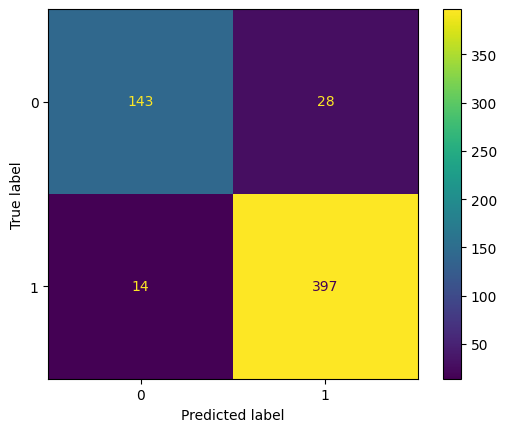

In [49]:
cm = confusion_matrix(y_test, y_test_pred_model_22)
ConfusionMatrixDisplay(cm).plot()

#### Model 25 (weighed loss function)

In [50]:
loaded_model_25 = XRAYS_CNN(input_shape=1,
    hidden_units=5,
    output_shape=1
)

loaded_model_25.to(device)
# Load model state dict
loaded_model_25.load_state_dict(torch.load('models/model_25.pth', map_location=torch.device(device) ))

#Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_25.to(device)

print(f"Loaded model:\n{loaded_model_25}")
print(f"Model on device:\n{next(loaded_model_25.parameters()).device}")

Loaded model:
XRAYS_CNN(
  (block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128000, out_features=1, bias=True)
  )
)
Model on device:
cpu


In [51]:
test_results_model_25, y_test, y_test_pred_model_25 = test(data_loader=test_dataloader,
                                                            model=loaded_model_25,
                                                            accuracy_fn=accuracy_fn,
                                                            device=device)

In [52]:
test_results_model_25

{'test_acc': 93.53070175438596, 'test_f1': 0.9578820697954272}

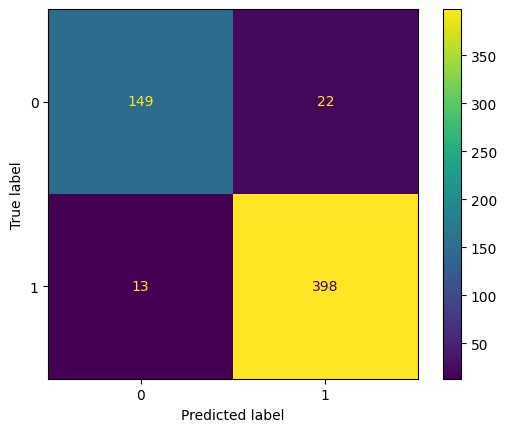

In [53]:
cm = confusion_matrix(y_test, y_test_pred_model_25)
ConfusionMatrixDisplay(cm).plot()